## INF0619 - Final Project

Team Overflow - Students:

- Arthur Jardim Rodrigues Mochon
- Bruno Alexandre Rosa
- Felipe Galileu Martins
- Jonathas Antunes Batista
- Nickolas Souza Voss
- Rafael Hummel Santos


## Financial News Sentiment Analysis

## 1. Introduction and Project Context

This notebook presents a complete solution for the **Financial News Sentiment Analysis** challenge. The goal is to classify short news texts into three sentiment categories:

- **Positive**
- **Negative**
- **Neutral**

### Specific Objectives

1.  **Exploratory Data Analysis (EDA)**: Understand the nature of the data, class distribution, and textual characteristics.
2.  **Preprocessing**: Clean and transform textual data into numerical formats suitable for ML and DL models.
3.  **Modeling**: Implement and compare different approaches:
    - _Baselines_: Logistic Regression.
    - _Tree Models_: Random Forest and XGBoost.
    - _Deep Learning_: Bidirectional LSTM (to capture sequential context).
    - _Transformers_
    - _LLMs_: local and cloud-based
4.  **Optimization**: Hyperparameter tuning, Ensemble (Voting Classifier), and fine-tuning (Transformers).
5.  **Explainability**: Understand which words drive the predictions.


In [1]:
%load_ext autoreload
%autoreload 2

# --- Library Imports ---
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.utils import compute_sample_weight

# XGBoost
import xgboost as xgb

# TensorFlow/Keras (only for LSTM)
import tensorflow as tf

# PyTorch & Transformers
import torch

# Progress bar
from tqdm import tqdm

# Import from src modules
from src import config
from src.config import DEFAULT_TRAINING_ARGS
from src import data_loader
from src import preprocessing
from src import utils
from src import evaluation
from src import submission
from src.models import classical
from src.models import lstm
from src.models import transformers
from src.models import llm

# Global Configuration - seeds are set automatically when config is imported
SEED = config.SEED
sns.set(style="whitegrid", palette="muted")
%matplotlib inline

pd.set_option('max_colwidth', None)

# Dictionaries to store results
results_val = {}
results_test = {}
results_val_per_type = {}
results_test_per_type = {}

print("Libraries loaded and configured.")

/Users/bruno/ws/inf0619_final_project/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Libraries loaded and configured.


## 2. Data Loading and Exploratory Data Analysis (EDA)

In this section, we will load the data and answer fundamental questions about the dataset to guide our modeling strategy.


In [2]:
# Dataset Loading (Financial PhraseBank)
df_fpb_train, df_fpb_val, df_fpb_test = data_loader.load_datasets()

print(f"Training Dimensions: {df_fpb_train.shape}")
print(f"Validation Dimensions: {df_fpb_val.shape}")
print(f"Test Dimensions: {df_fpb_test.shape}")

# Encode labels
y_train, y_val = data_loader.encode_labels(df_fpb_train, df_fpb_val)

# Displaying first rows
display(df_fpb_train.head(3))

Training Dimensions: (3876, 4)
Validation Dimensions: (485, 4)
Test Dimensions: (485, 2)


index  \
0   3146   
1    918   
2    318   

                                                                                                                                                                              text  \
0   TeliaSonera s subsidiary , the mobile operator EMT in Estonia , has created a world s first mobile identification service which makes it possible to vote via a mobile phone .   
1                                                           Validating our fgVoIP client through Symbian Signed represents a significant step forward in accomplishing this goal .   
2  1 February 2011 - Finnish textile and clothing company Marimekko Oyj HEL : MMO1V said today its preliminary operating profit grew to EUR8 .2 m in 2010 from EUR6 .3 m in 2009 .   

      label  label_encoded  
0   neutral              0  
1  positive              1  
2  positive              1

### Exploratory Analysis


/var/folders/6z/x30k7lfx3s14wgz7gd9kb3yh0000gn/T/ipykernel_24972/1929593114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


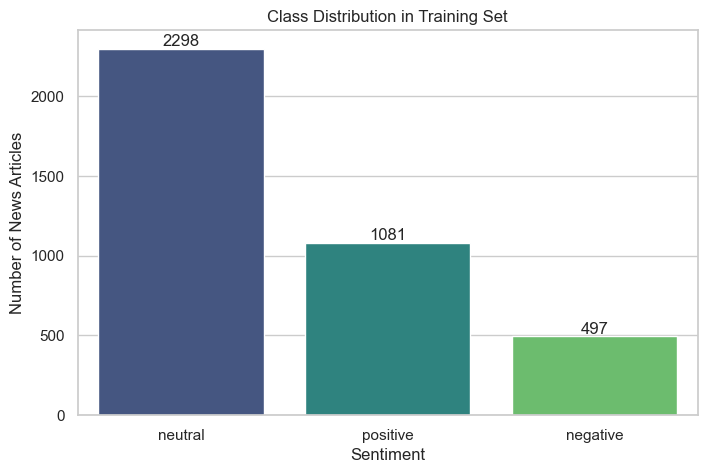

Class Proportions (%):
label
neutral     59.287926
positive    27.889577
negative    12.822497
Name: proportion, dtype: float64


In [3]:
# Check class distribution. Is the dataset imbalanced?
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="label",
    data=df_fpb_train,
    order=["neutral", "positive", "negative"],
    palette="viridis",
)
plt.title("Class Distribution in Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Number of News Articles")

# Add count on bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.show()

# Calculate proportions
distribuicao = df_fpb_train["label"].value_counts(normalize=True) * 100
print("Class Proportions (%):")
print(distribuicao)

/var/folders/6z/x30k7lfx3s14wgz7gd9kb3yh0000gn/T/ipykernel_24972/2294781365.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


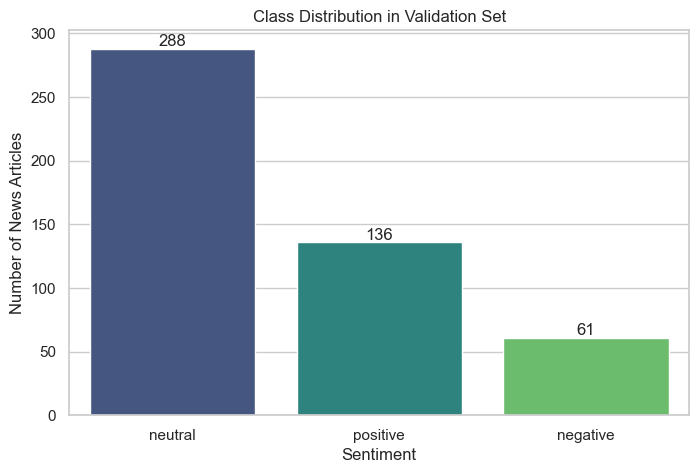

Class Proportions (%):
label
neutral     59.381443
positive    28.041237
negative    12.577320
Name: proportion, dtype: float64


In [4]:

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="label",
    data=df_fpb_val,
    order=["neutral", "positive", "negative"],
    palette="viridis",
)
plt.title("Class Distribution in Validation Set")
plt.xlabel("Sentiment")
plt.ylabel("Number of News Articles")

# Add count on bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.show()

# Calculate proportions
distribuicao = df_fpb_val["label"].value_counts(normalize=True) * 100
print("Class Proportions (%):")
print(distribuicao)

The dataset is **imbalanced** in both the training and validation splits. The 'neutral' class is the majority (common in factual financial news). This motivates the use of the **Balanced Accuracy** metric and the `class_weight='balanced'` parameter in models to avoid bias towards the majority class.


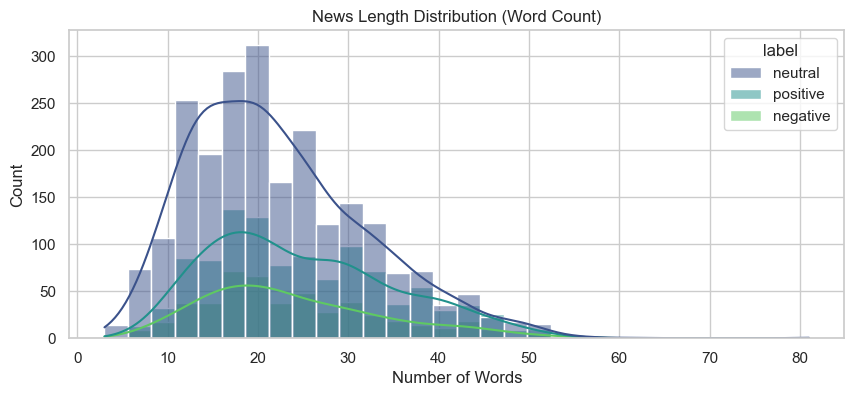

Average words: 23.19
Maximum words: 81


In [5]:
# Exploring news length
df_fpb_train["word_count"] = df_fpb_train["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 4))
sns.histplot(
    data=df_fpb_train, x="word_count", hue="label", kde=True, bins=30, palette="viridis"
)
plt.title("News Length Distribution (Word Count)")
plt.xlabel("Number of Words")
plt.show()

print(f"Average words: {df_fpb_train['word_count'].mean():.2f}")
print(f"Maximum words: {df_fpb_train['word_count'].max()}")

The news articles are short (titles or headlines). This suggests that **TF-IDF**-based models may work very well, as the sequential complexity is lower than in long documents. Still, we will test **LSTMs** to capture nuances.


## 3. Text Preprocessing

To prepare the data, we will apply the following techniques:

1.  **Cleaning**: Remove special characters, numbers, and convert to lowercase. We will keep only letters.
2.  **Stopwords**: Removal of common words (the, is, at) that do not carry sentiment.
3.  **Vectorization**:
    - **TF-IDF** for classical models (ML).
    - **Tokenization and Padding** for Deep Learning/Transformers (DL).


In [6]:
# Applying cleaning
df_fpb_train["clean_text"] = df_fpb_train["text"].apply(preprocessing.clean_text)
df_fpb_val["clean_text"] = df_fpb_val["text"].apply(preprocessing.clean_text)
df_fpb_test["clean_text"] = df_fpb_test["text"].apply(preprocessing.clean_text)

# --- TF-IDF Vectorization ---
tfidf = preprocessing.create_tfidf_vectorizer()
X_train_tfidf, X_val_tfidf, X_test_tfidf = preprocessing.fit_transform_tfidf(
    tfidf,
    df_fpb_train["clean_text"],
    df_fpb_val["clean_text"],
    df_fpb_test["clean_text"]
)

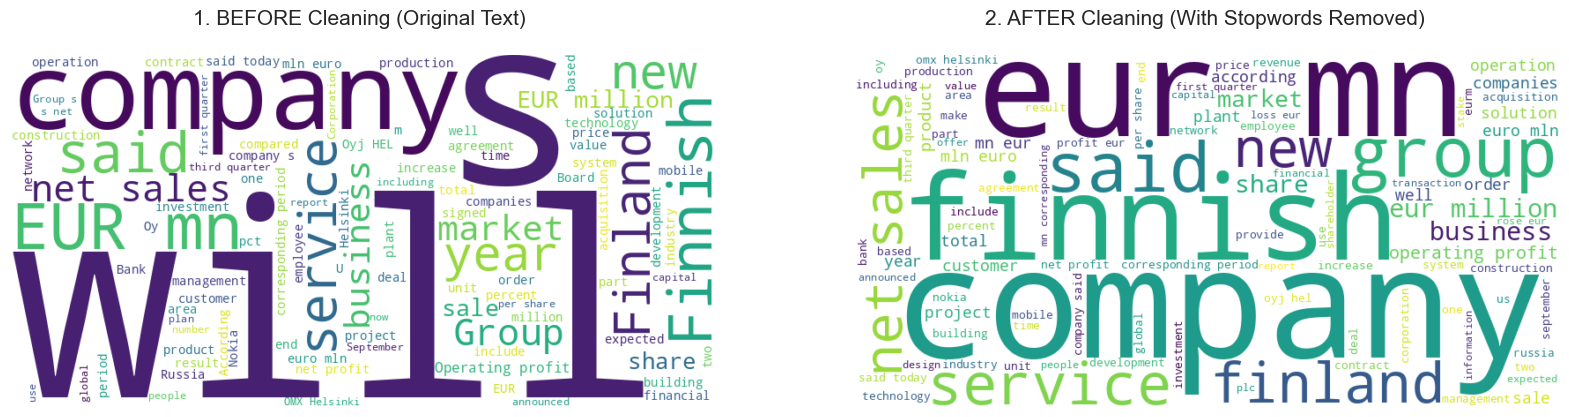

In [7]:
# --- Generation and Comparison ---

# 1. Figure Preparation
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 2. Word Cloud BEFORE Cleaning
# Use the original 'text' column
utils.generate_word_cloud(
    df_fpb_train["text"], "1. BEFORE Cleaning (Original Text) \n", axes[0]
)

# 3. Word Cloud AFTER Cleaning
# Use the 'clean_text' column, where stopwords, punctuation, and lowercase have been applied
utils.generate_word_cloud(
    df_fpb_train["clean_text"],
    "2. AFTER Cleaning (With Stopwords Removed) \n",
    axes[1],
)

plt.show()

## 4. Modeling and Training

We will test a variety of models to find the best performance. The main metric will be **Balanced Accuracy**.

### Model Strategy:

1.  **Logistic Regression**: Robust baseline for text classification with TF-IDF.
2.  **XGBoost**: Tree-based model (Gradient Boosting), excellent for capturing non-linearities.
3.  **Random Forest (Tuned)**: Bagging of trees, optimized via Grid Search.
4.  **SVM (Tuned)**: Support Vector Machines, effective in high-dimensional spaces.
5.  **Bidirectional LSTM**: Recurrent Neural Network that reads text in both directions, capturing context.
6.  **Voting Classifier**: Ensemble combining the best previous models.
7.  **Transformers**: Evaluation of various models with and without fine-tuning.
8.  **LLMs**: Both local and cloud-based models.


## Helper Code


In [8]:
# Compute sample weights
sample_weights = compute_sample_weight("balanced", y_train)

## 4.1 Classical Models


In [9]:
model_type_classic_ml = "Classical Machine Learning"
results_val_per_type[model_type_classic_ml] = {}
results_test_per_type[model_type_classic_ml] = {}

### 4.1.1 Logistic Regression (Baseline)


Evaluating on validation set...

--- Training Logistic Regression without class balancing ---
> Logistic Regression without class balancing Balanced Accuracy: 0.62615


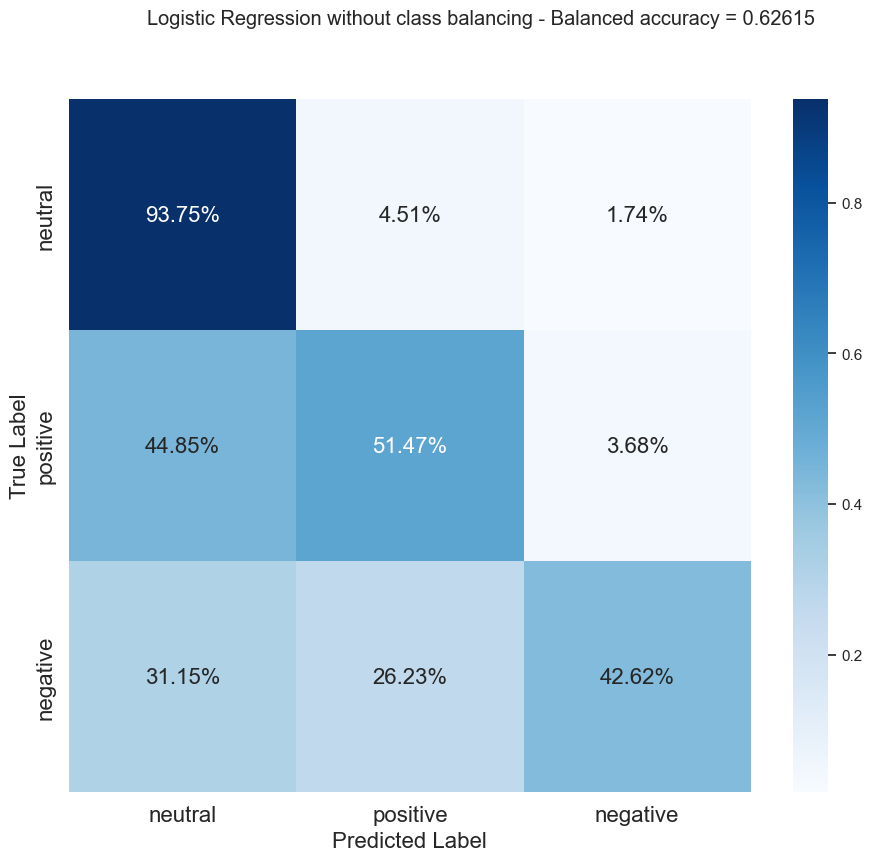

In [10]:
# Logistic Regression (Baseline without class weight balancing)
lr_wo_weight_name = "Logistic Regression without class balancing"

print("Evaluating on validation set...")
lr_wo_weight = classical.train_and_eval(
    LogisticRegression(class_weight=None, max_iter=1000, random_state=SEED),
    lr_wo_weight_name,
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    results_dict=results_val,
)

results_val_per_type[model_type_classic_ml][lr_wo_weight_name] = results_val[
    lr_wo_weight_name
]

Without balancing, the results are quite biased towards the neutral class, which is the most frequent in the dataset.

Evaluating on validation set...

--- Training Logistic Regression ---
> Logistic Regression Balanced Accuracy: 0.71424


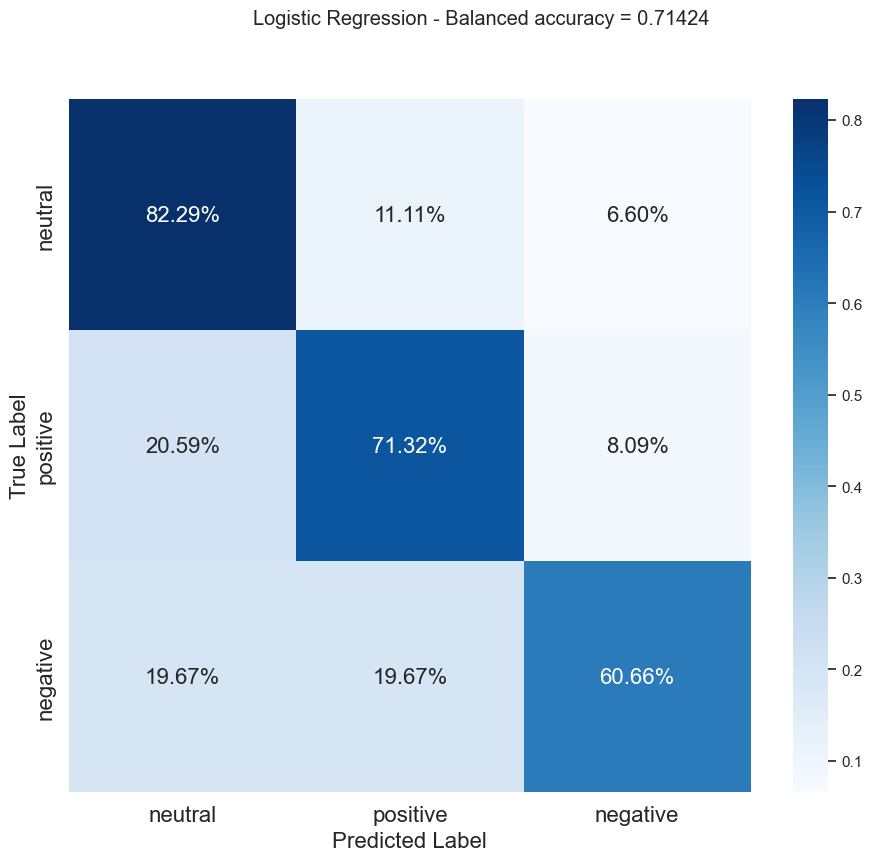

File 'submissions/submission_baseline.csv' generated successfully!


ID  TARGET
0   0       2
1   1       0
2   2       0
3   3       0
4   4       1

In [11]:
# Logistic Regression (Baseline)
lr_name = "Logistic Regression"

print("Evaluating on validation set...")
lr = classical.train_and_eval(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=SEED),
    "Logistic Regression",
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    results_dict=results_val,
)

results_val_per_type[model_type_classic_ml][lr_name] = results_val[lr_name]

# Create submission DataFrame
pred_baseline = lr.predict(X_test_tfidf)
submission.generate_submission(pred_baseline, df_fpb_test, "baseline")
display(pd.DataFrame({"ID": df_fpb_test["ID"], "TARGET": pred_baseline}).head())

With balancing, the bias towards the neutral class decreases, but the model has difficulty correctly classifying negative samples, confusing them with neutral 19.67% of the time and also with positive 19.67% of the time.

In [12]:
results_test[lr_name] = 0.69940
results_test_per_type[model_type_classic_ml][lr_name] = results_test[lr_name]

Accuracy on test set (via Kaggle): **0.69940**


### 4.1.2 eXtreme Gradient Boost (XGB)


Evaluating on validation set...

--- Training XGBoost without class balancing ---
> XGBoost without class balancing Balanced Accuracy: 0.66530


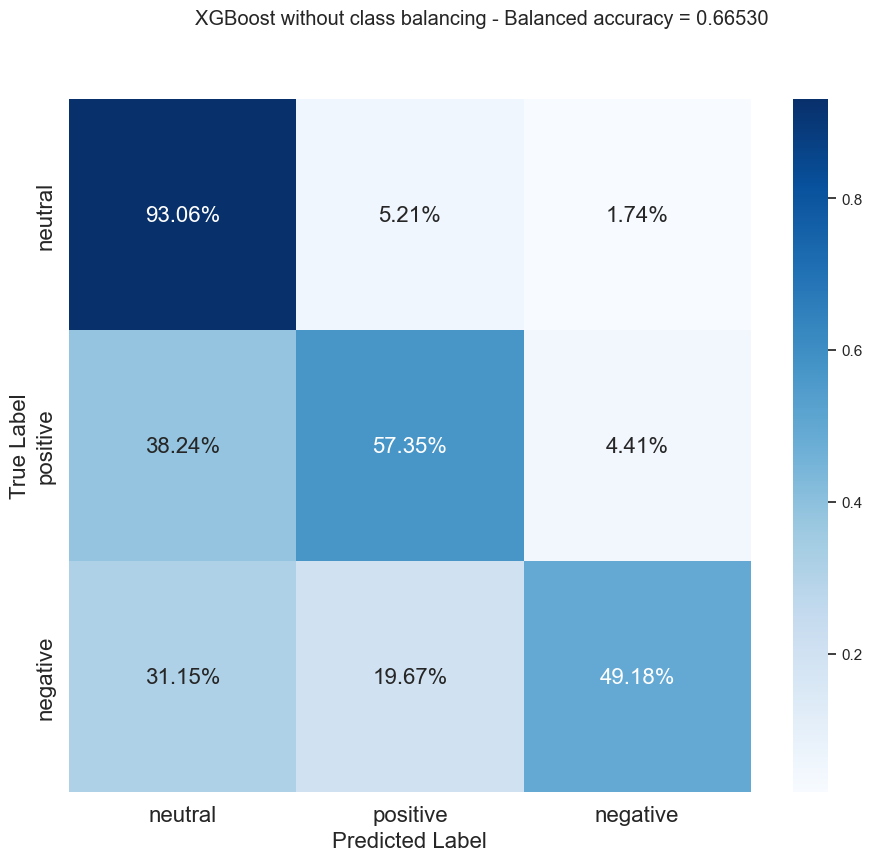

In [13]:
# XGBoost without class weight balancing
xgb_wo_weight_name = "XGBoost without class balancing"

print("Evaluating on validation set...")
xgb_model_wo_weight = classical.train_and_eval(
    xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        random_state=SEED,
        eval_metric="mlogloss",
    ),
    xgb_wo_weight_name,
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    results_dict=results_val,
)

results_val_per_type[model_type_classic_ml][xgb_wo_weight_name] = results_val[
    xgb_wo_weight_name
]

Again, without balancing, the model shows a bias towards the neutral class, which is the most frequent in the dataset.

Evaluating on validation set...

--- Training XGBoost ---
> XGBoost Balanced Accuracy: 0.69696


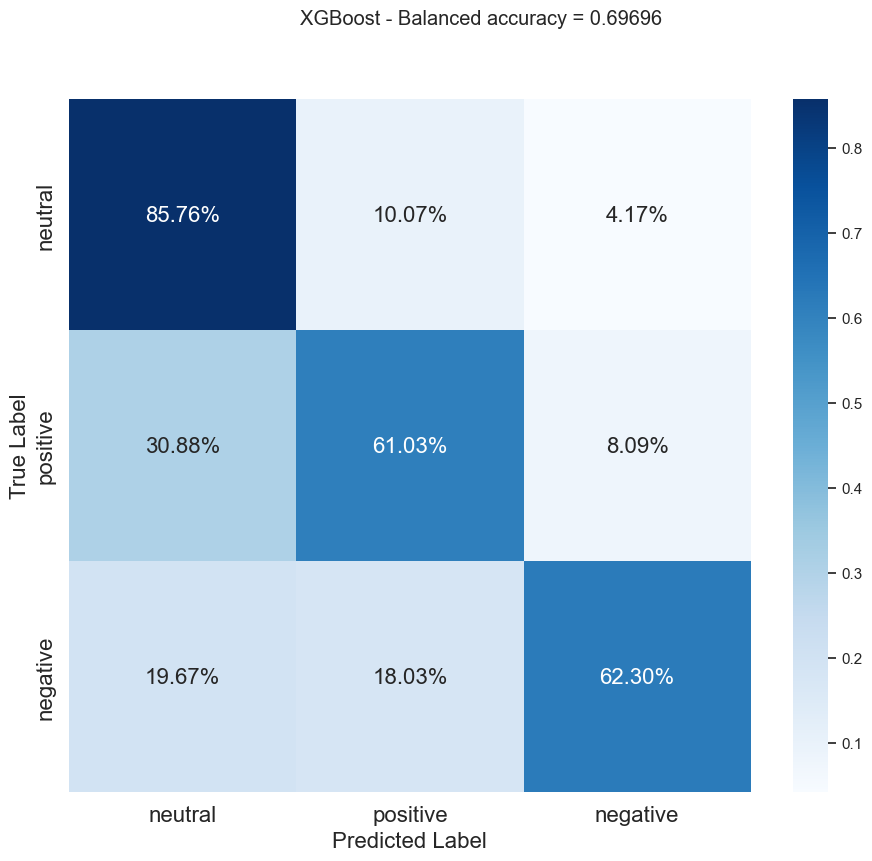

File 'submissions/submission_XGB.csv' generated successfully!


ID  TARGET
0   0       2
1   1       0
2   2       0
3   3       0
4   4       1

In [14]:
# XGBoost
xgb_name = "XGBoost"
print("Evaluating on validation set...")
xgb_model = classical.train_and_eval(
    xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        random_state=SEED,
        eval_metric="mlogloss",
    ),
    xgb_name,
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    sample_weights=sample_weights,
    results_dict=results_val,
)

results_val_per_type[model_type_classic_ml][xgb_name] = results_val[xgb_name]
# Create submission DataFrame
final_pred = xgb_model.predict(X_test_tfidf)
submission.generate_submission(final_pred, df_fpb_test, "XGB")
display(pd.DataFrame({"ID": df_fpb_test["ID"], "TARGET": final_pred}).head())

As with logistic regression, using class weight balancing reduces the bias towards the neutral class.

However, performance remains modest at around 70% balanced accuracy.

In [15]:
results_test[xgb_name] = 0.70278
results_test_per_type[model_type_classic_ml][xgb_name] = results_test[xgb_name]

Accuracy on test set (via Kaggle): **0.70278**


### 4.1.3 Random Forest



--- Optimizing Random Forest ---


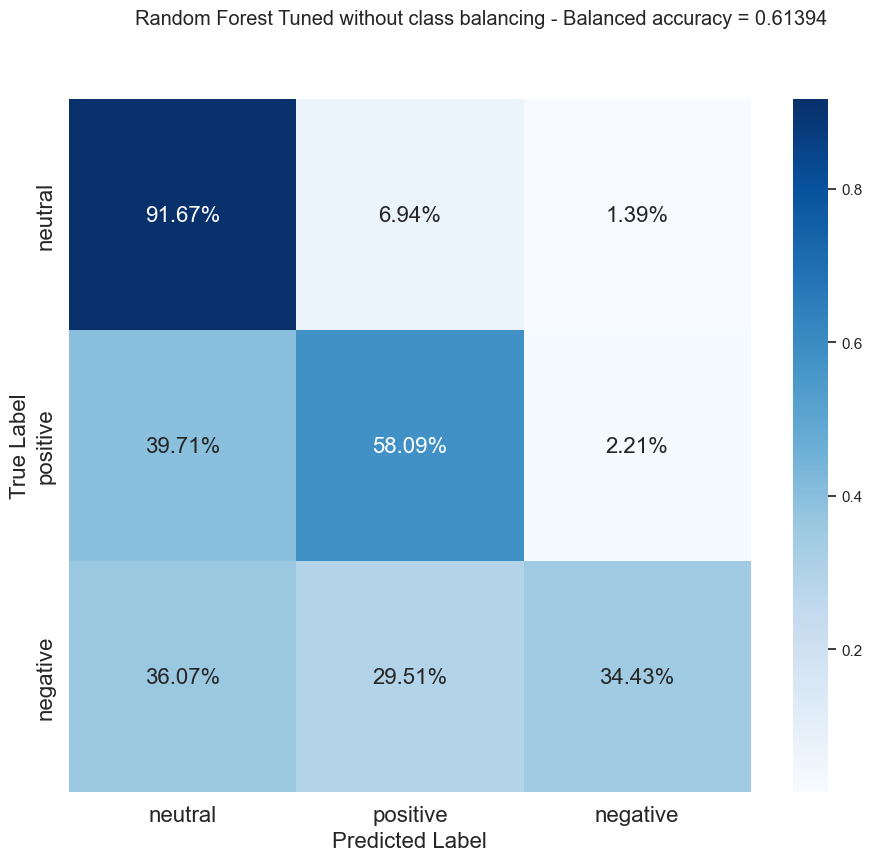

Evaluating on validation set...
> Best RF Params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
> RF Tuned Acc: 0.61394


In [16]:
# Random Forest without class weight balancing (Grid Search)
best_rf_wo_weight = classical.train_random_forest(
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    class_weight=None,
    results_dict=results_val,
)
rf_wo_weight_name = "Random Forest Tuned without class balancing"
results_val_per_type[model_type_classic_ml][rf_wo_weight_name] = results_val[
    rf_wo_weight_name
]

Without balancing, the model shows a bias towards the neutral class, which is the most frequent in the dataset.


--- Optimizing Random Forest ---


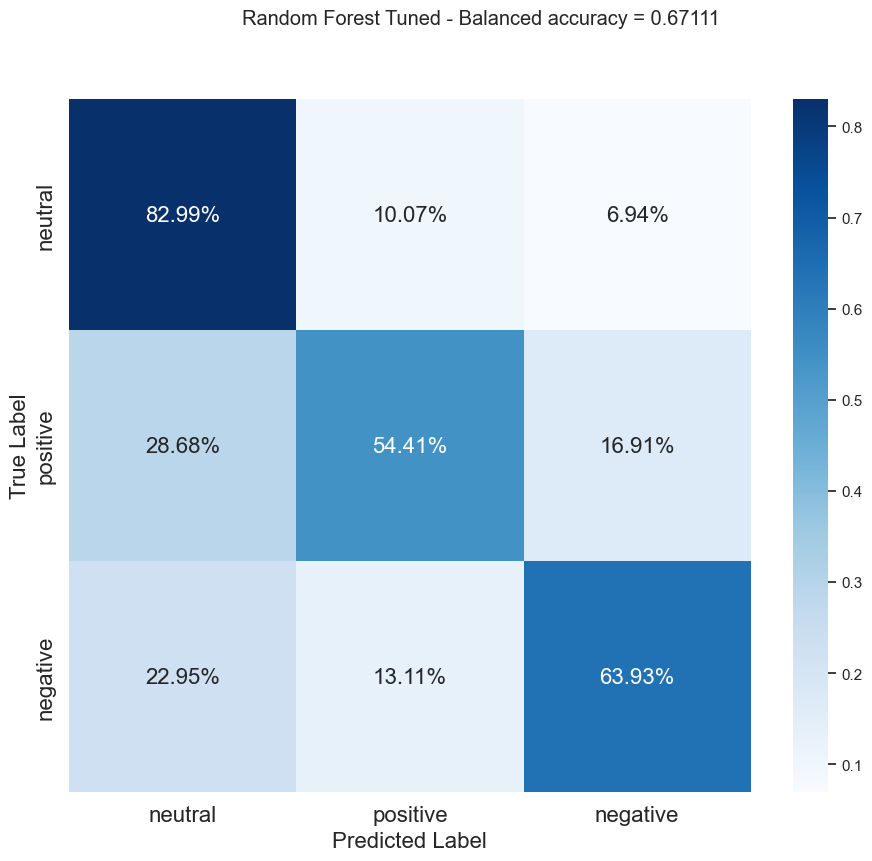

Evaluating on validation set...
> Best RF Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
> RF Tuned Acc: 0.67111
File 'submissions/submission_RF.csv' generated successfully!


ID  TARGET
0   0       2
1   1       0
2   2       0
3   3       0
4   4       0

In [17]:
# Random Forest (Grid Search)
best_rf = classical.train_random_forest(
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    class_weight="balanced",
    results_dict=results_val,
)
rf_name = "Random Forest Tuned"
results_val_per_type[model_type_classic_ml][rf_name] = results_val[rf_name]

# Create submission DataFrame
final_pred = best_rf.predict(X_test_tfidf)
submission.generate_submission(final_pred, df_fpb_test, "RF")
display(pd.DataFrame({"ID": df_fpb_test["ID"], "TARGET": final_pred}).head())

Again, using class balancing reduces the bias towards the neutral class.

Still, the performance on the training set was the lowest among the classical models.

In [18]:
results_test[rf_name] = 0.68307
results_test_per_type[model_type_classic_ml][rf_name] = results_test[rf_name]

Accuracy on test set (via Kaggle): **0.68307**


### 4.1.4 Support Vector Machines (SVM)



--- Optimizing SVM ---


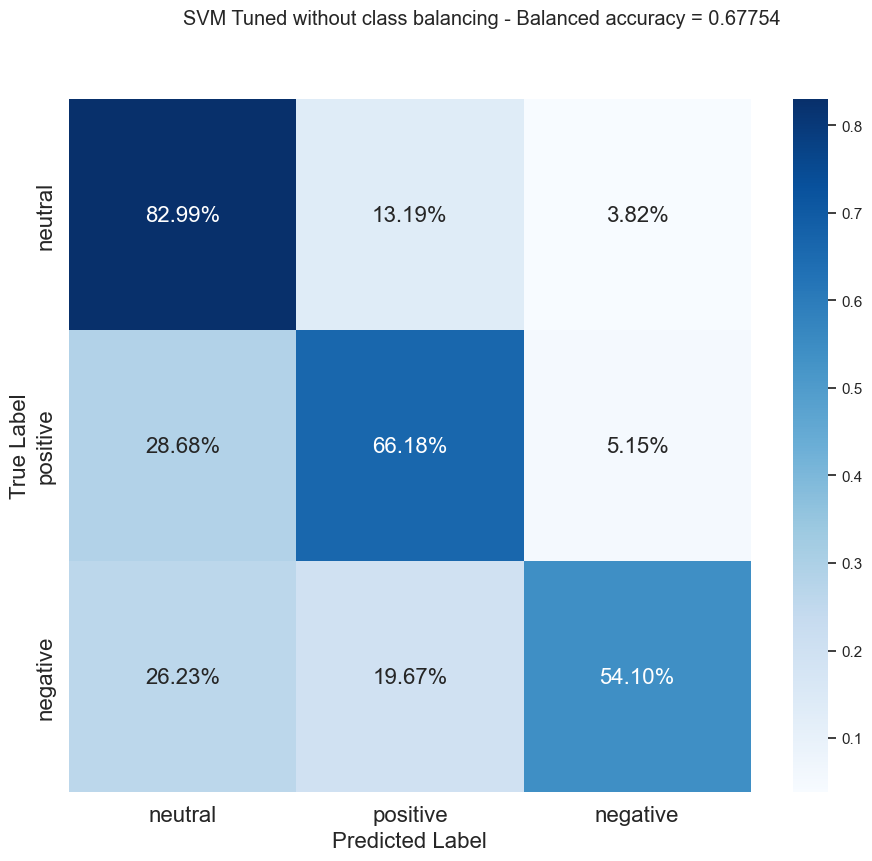

Evaluating on validation set...
> Best SVM Params: {'C': 10, 'class_weight': None, 'kernel': 'linear'}
> SVM Tuned Acc: 0.67754


In [19]:
# SVM without class weight balancing (Grid Search)
best_svm_wo_weight = classical.train_svm(
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    class_weight=None,
    results_dict=results_val,
)
svm_wo_weight_name = "SVM Tuned without class balancing"
results_val_per_type[model_type_classic_ml][svm_wo_weight_name] = results_val[
    svm_wo_weight_name
]

Without balancing, there is a large bias towards the neutral class, which is more frequent in the dataset.


--- Optimizing SVM ---


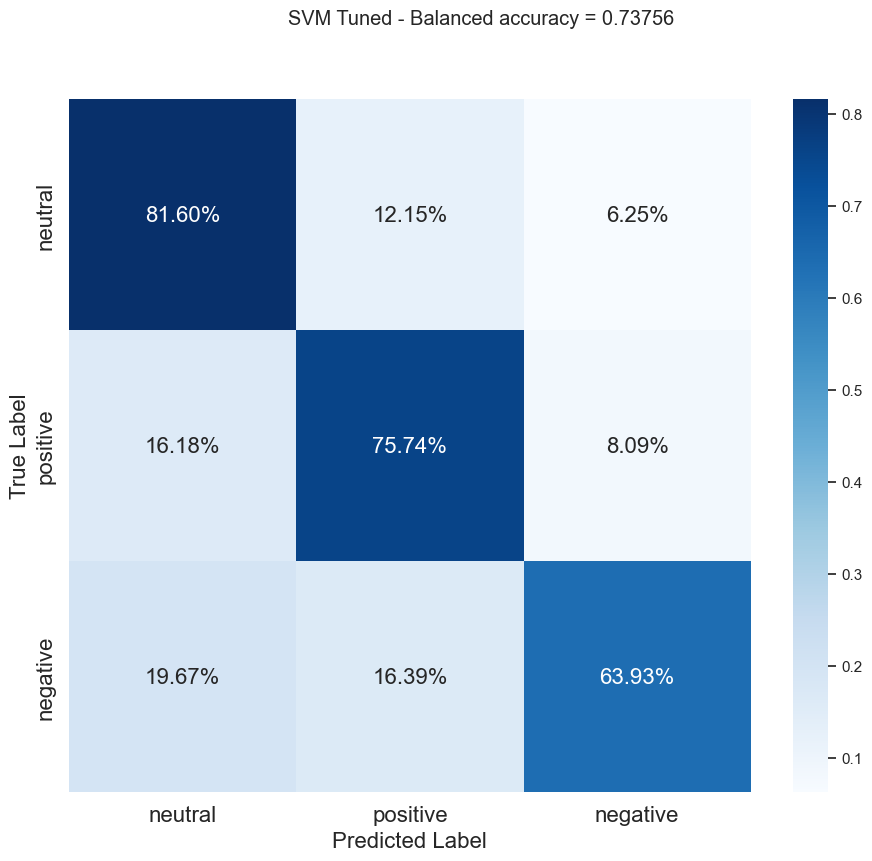

Evaluating on validation set...
> Best SVM Params: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
> SVM Tuned Acc: 0.73756
File 'submissions/submission_SVM.csv' generated successfully!


ID  TARGET
0   0       2
1   1       0
2   2       0
3   3       0
4   4       1

In [20]:
# SVM (Grid Search)
best_svm = classical.train_svm(
    X_train_tfidf,
    y_train,
    X_val_tfidf,
    y_val,
    class_weight="balanced",
    results_dict=results_val,
)
svm_name = "SVM Tuned"
results_val_per_type[model_type_classic_ml][svm_name] = results_val[svm_name]

# Create submission DataFrame
final_pred = best_svm.predict(X_test_tfidf)
submission.generate_submission(final_pred, df_fpb_test, "SVM")
display(pd.DataFrame({"ID": df_fpb_test["ID"], "TARGET": final_pred}).head())

Class balancing reduces the bias towards the neutral class.

The model shows the best performance among classical models with approximately 74% balanced accuracy, with ~82% for neutral, ~76% for positive and ~64% for negative - still indicating difficulty in classifying samples from less frequent classes.

In [21]:
results_test[svm_name] = 0.70781
results_test_per_type[model_type_classic_ml][svm_name] = results_test[svm_name]

Accuracy on test set (via Kaggle): **0.70781**


### 4.1.5 Ensemble: Voting Classifier

We will combine the classical ML models (Logistic Regression, XGBoost, RF, SVM) to try to obtain better generalization.


> Voting Ensemble without class balancing Acc: 0.70986


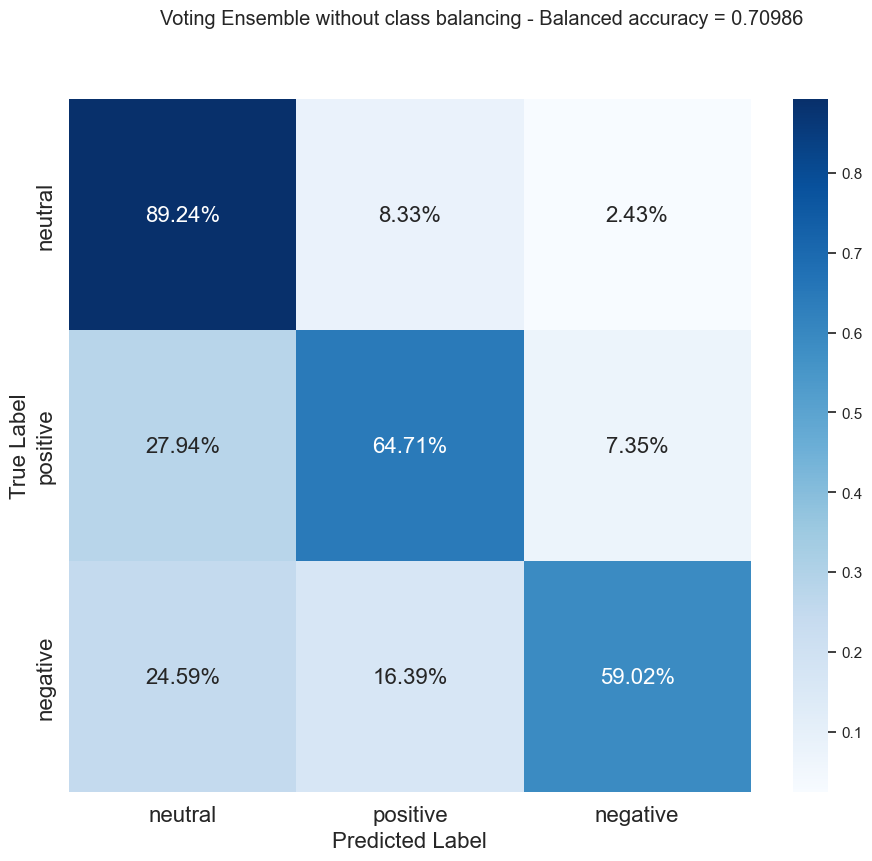

In [22]:
voting_clf_wo_weight_name = "Voting Ensemble without class balancing"

voting_clf_wo_weight = classical.train_voting_classifier(
    estimators=[
        ("lr", lr_wo_weight),
        ("xgb", xgb_model_wo_weight),
        ("rf", best_rf_wo_weight),
        ("svm", best_svm_wo_weight),
    ],
    X_train=X_train_tfidf,
    y_train=y_train,
    X_val=X_val_tfidf,
    y_val=y_val,
    sample_weights=sample_weights,
    voting="soft",
    name=voting_clf_wo_weight_name,
    results_dict=results_val,
)

results_val_per_type[model_type_classic_ml][voting_clf_wo_weight_name] = results_val[
    voting_clf_wo_weight_name
]

> Voting Ensemble Acc: 0.72220


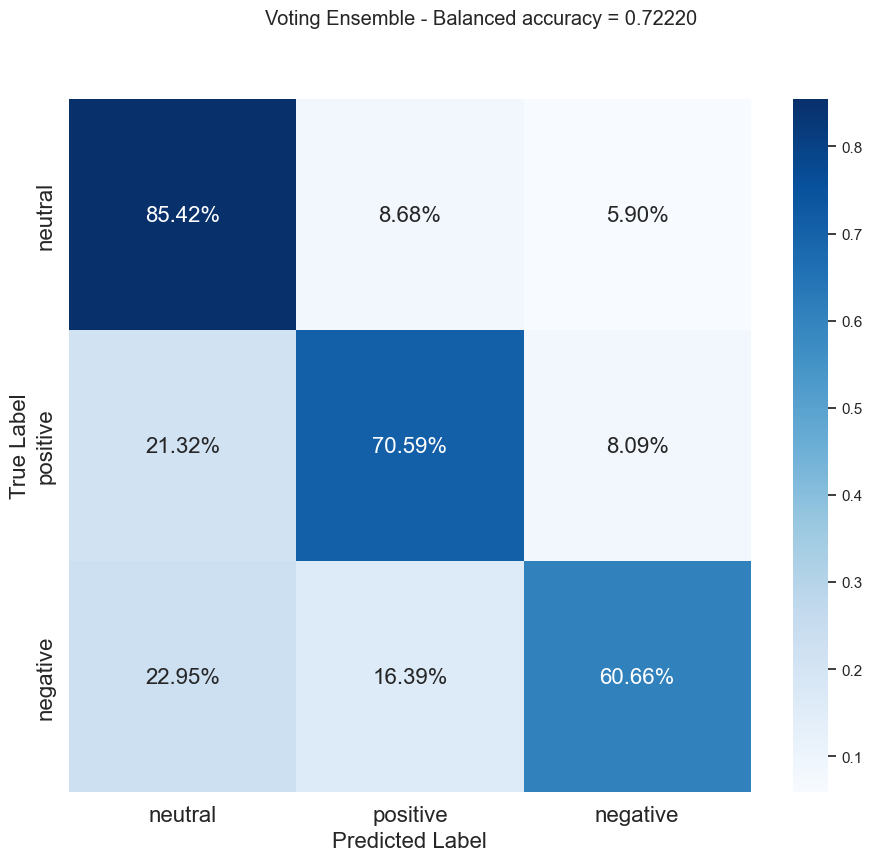

File 'submissions/submission_Voting.csv' generated successfully!


ID  TARGET
0   0       2
1   1       0
2   2       0
3   3       0
4   4       1

In [23]:
voting_clf_name = "Voting Ensemble"

voting_clf = classical.train_voting_classifier(
    estimators=[("lr", lr), ("xgb", xgb_model), ("rf", best_rf), ("svm", best_svm)],
    X_train=X_train_tfidf,
    y_train=y_train,
    X_val=X_val_tfidf,
    y_val=y_val,
    sample_weights=sample_weights,
    voting="soft",
    results_dict=results_val,
)

results_val_per_type[model_type_classic_ml][voting_clf_name] = results_val[
    voting_clf_name
]

final_pred = voting_clf.predict(X_test_tfidf)

# Create submission DataFrame
submission.generate_submission(final_pred, df_fpb_test, "Voting")
display(pd.DataFrame({"ID": df_fpb_test["ID"], "TARGET": final_pred}).head())

In [24]:
results_test[voting_clf_name] = 0.70434
results_test_per_type[model_type_classic_ml][voting_clf_name] = results_test[
    voting_clf_name
]

Accuracy on test set (via Kaggle): **0.70434**


### 4.1.6 Results Comparison: with and without class balancing


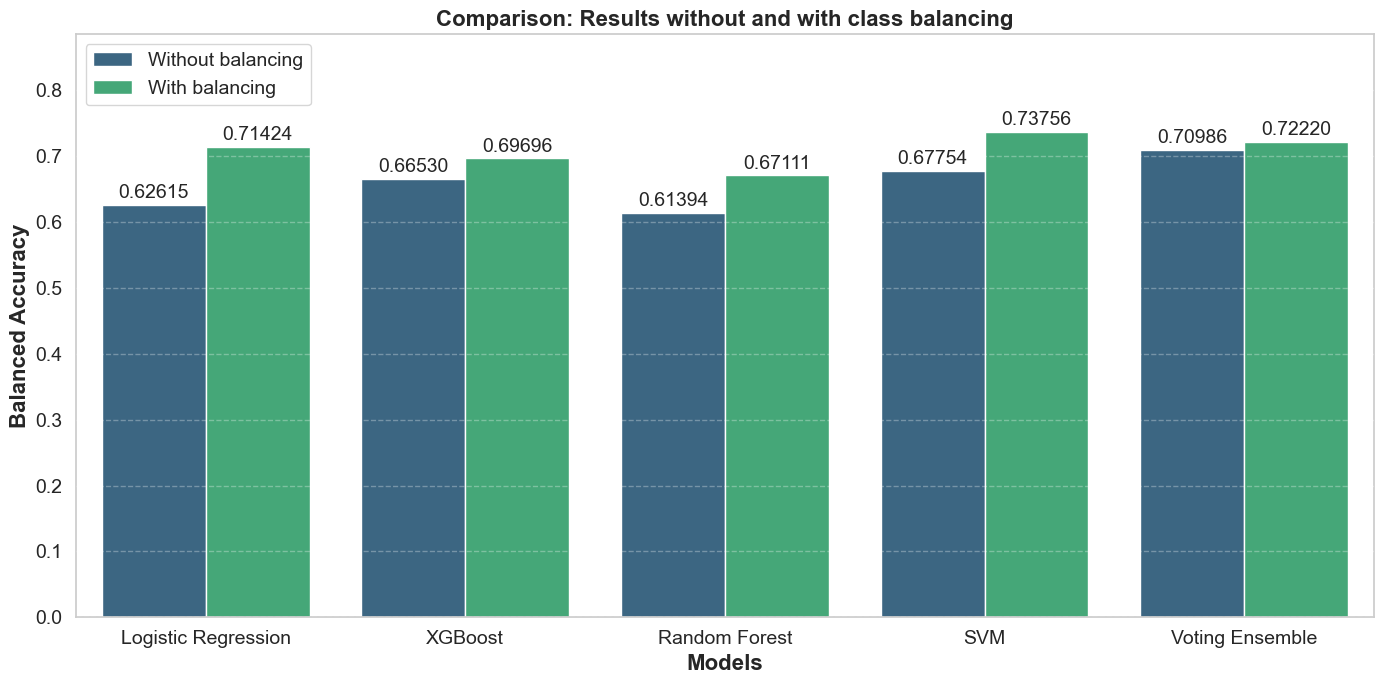

In [25]:
# Based on https://python-graph-gallery.com/11-grouped-barplot/

# Mapping of keys in the `results` dictionary
key_mapping = {
    "Logistic Regression": {
        "without": "Logistic Regression without class balancing",
        "with": "Logistic Regression",
    },
    "XGBoost": {"without": "XGBoost without class balancing", "with": "XGBoost"},
    "Random Forest": {
        "without": "Random Forest Tuned without class balancing",
        "with": "Random Forest Tuned",
    },
    "SVM": {"without": "SVM Tuned without class balancing", "with": "SVM Tuned"},
    "Voting Ensemble": {
        "without": "Voting Ensemble without class balancing",
        "with": "Voting Ensemble",
    },
}

# Create DataFrame using list comprehension
model_names = [
    "Logistic Regression",
    "XGBoost",
    "Random Forest",
    "SVM",
    "Voting Ensemble",
]

df_plot = pd.DataFrame(
    [
        {
            "Model": m,
            "Type": t,
            "Balanced Accuracy": results_val.get(
                key_mapping[m]["without" if t == "Without balancing" else "with"], 0
            ),
        }
        for m in model_names
        for t in ["Without balancing", "With balancing"]
    ]
)

# Create plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=df_plot, x="Model", y="Balanced Accuracy", hue="Type", palette="viridis"
)

# Add values on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.5f", fontsize=14, padding=2)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

# Configure axes and title
ax.set_xlabel("Models", fontsize=16, fontweight="bold")
ax.set_ylabel("Balanced Accuracy", fontsize=16, fontweight="bold")
ax.set_title(
    "Comparison: Results without and with class balancing",
    fontsize=16,
    fontweight="bold",
)
ax.set_ylim(0, df_plot["Balanced Accuracy"].max() * 1.2)
ax.legend(title="", loc="upper left", frameon=True, fontsize=14)
ax.grid(True, axis="y", alpha=0.3, linestyle="--", zorder=1, color="white")
ax.set_axisbelow(False)
plt.tight_layout()
plt.show()

All evaluated classical models benefited from using class balancing. The impact was greater for logistic regression and smaller for the voting ensemble.

### Results Comparison - validation vs test


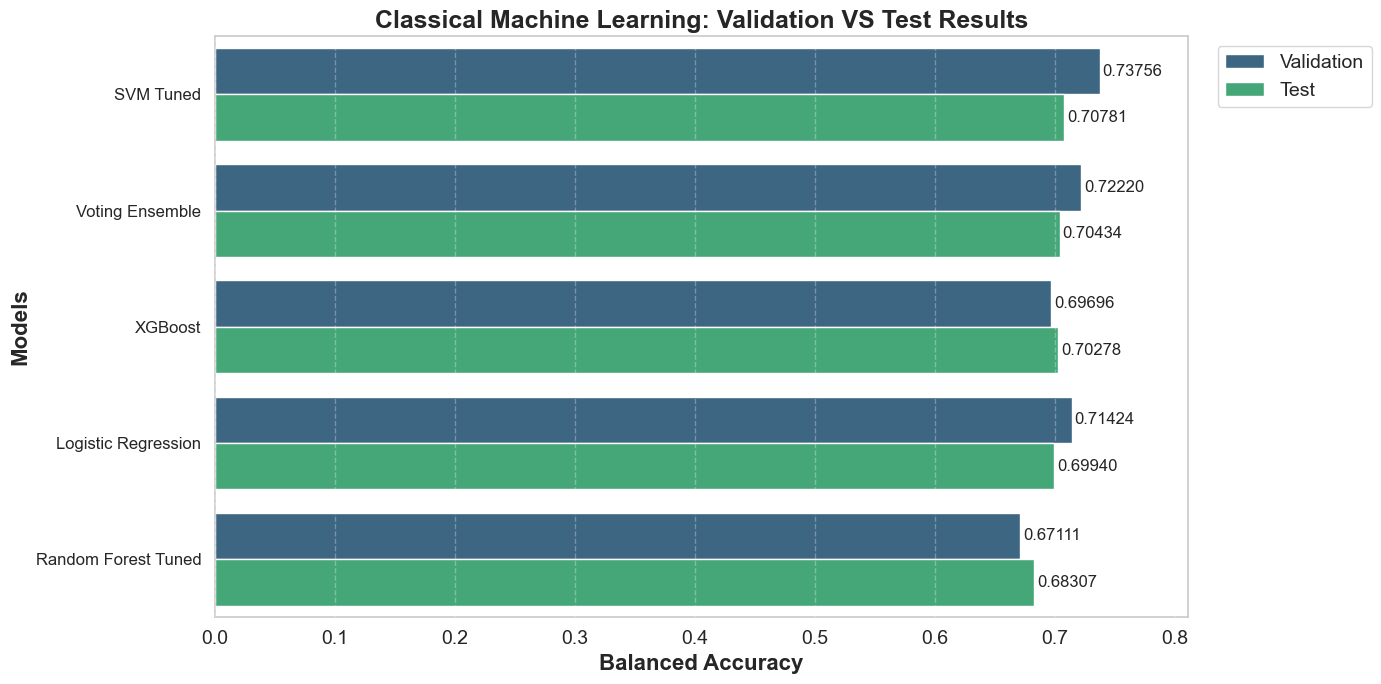

In [26]:
utils.plot_results_comparison(model_type_classic_ml, results_val_per_type, results_test_per_type)

 Overall, the models generalize well to the test set.

In [27]:
best_model_classic_ml_val = max(
    results_val_per_type[model_type_classic_ml],
    key=results_val_per_type[model_type_classic_ml].get,
)
print(f"Best classical ML model (validation): {best_model_classic_ml_val}")
print(
    f"  Accuracy: {results_val_per_type[model_type_classic_ml][best_model_classic_ml_val]:.5f}"
)

best_model_classic_ml_test = max(
    results_test_per_type[model_type_classic_ml],
    key=results_test_per_type[model_type_classic_ml].get,
)
print(f"\nBest classical ML model (test): {best_model_classic_ml_test}")
print(
    f"  Accuracy: {results_test_per_type[model_type_classic_ml][best_model_classic_ml_test]:.5f}"
)

Best classical ML model (validation): SVM Tuned
  Accuracy: 0.73756

Best classical ML model (test): SVM Tuned
  Accuracy: 0.70781


## 4.2 Deep Learning: Bidirectional LSTM

For the Deep Learning model, we need a different preprocessing approach: **Tokenization** and **Padding** to create fixed-size sequences.


In [28]:
model_type_dl = "Deep Learning"
results_val_per_type[model_type_dl] = {}
results_test_per_type[model_type_dl] = {}

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6029 - loss: 0.9177 - val_accuracy: 0.6928 - val_loss: 0.7816
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6870 - loss: 0.7293 - val_accuracy: 0.7134 - val_loss: 0.6921
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7583 - loss: 0.5787 - val_accuracy: 0.6866 - val_loss: 0.6937
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7977 - loss: 0.4825 - val_accuracy: 0.7010 - val_loss: 0.7050
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8527 - loss: 0.3716 - val_accuracy: 0.7526 - val_loss: 0.7101
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9025 - loss: 0.2801 - val_accuracy: 0.7567 - val_loss: 0.7319
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9265 - loss: 0.2134 - val_accuracy: 0.7856 - val_loss: 0.8218
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9445 - loss: 0.1675 - val_accuracy: 0.758

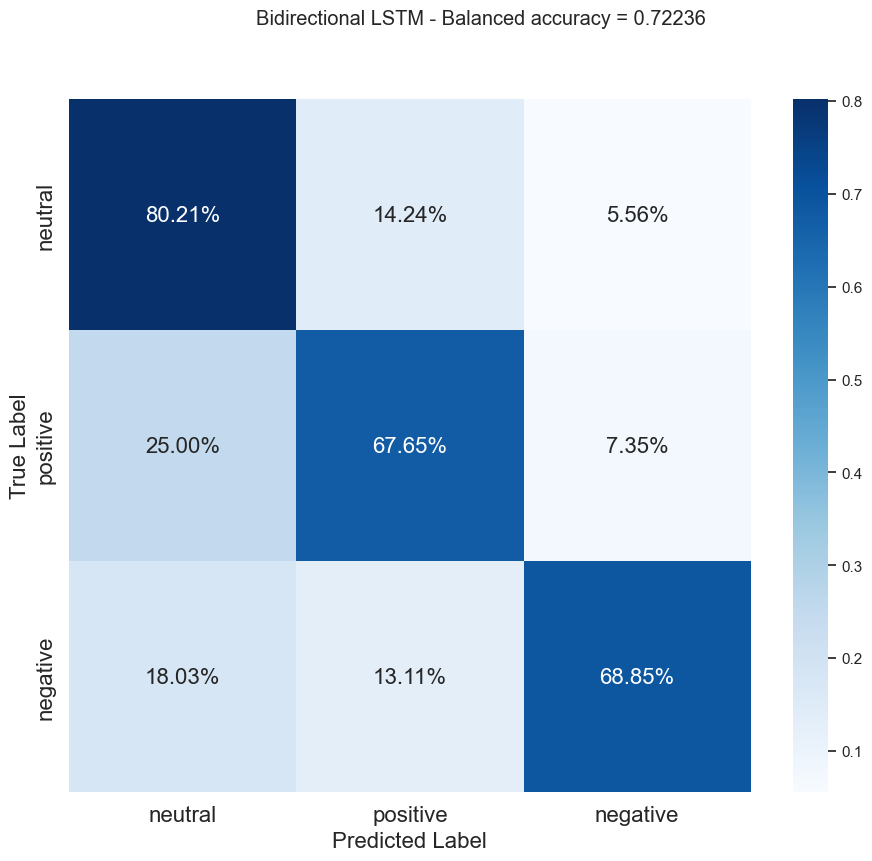

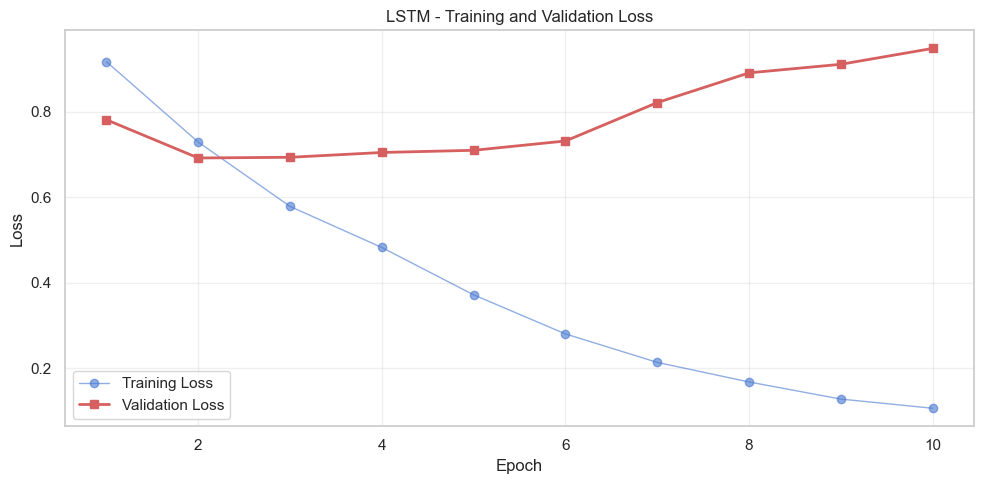

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
File 'submissions/submission_LSTM.csv' generated successfully!


ID  TARGET
0   0       2
1   1       0
2   2       0
3   3       0
4   4       1

In [29]:
bidirectional_lstm_name = "Bidirectional LSTM"

# Tokenization using preprocessing module
tokenizer_lstm = preprocessing.create_lstm_tokenizer()
X_train_seq, X_val_seq, X_test_seq = preprocessing.fit_transform_lstm(
    tokenizer_lstm,
    df_fpb_train["text"],
    df_fpb_val["text"],
    df_fpb_test["text"],
)

# Train and evaluate LSTM
model_lstm, history_lstm, acc, y_pred_lstm = lstm.train_and_evaluate_lstm(
    X_train_seq, y_train, X_val_seq, y_val,
    epochs=10, batch_size=64, results_dict=results_val,
)

results_val_per_type[model_type_dl][bidirectional_lstm_name] = results_val[
    bidirectional_lstm_name
]

# Generate predictions for test set
pred_prob = model_lstm.predict(X_test_seq)
final_pred = np.argmax(pred_prob, axis=1)

# Create submission DataFrame
submission.generate_submission(final_pred, df_fpb_test, "LSTM")
display(pd.DataFrame({"ID": df_fpb_test["ID"], "TARGET": final_pred}).head())

The training indicates signs of overfitting. 

The confusion matrix indicates that there is still some bias towards the neutral class. On the other hand, the performance of positive and negative classes became more balanced: ~68% and ~69% respectively.

In [30]:
results_test[bidirectional_lstm_name] = 0.70054
results_test_per_type[model_type_dl][bidirectional_lstm_name] = results_test[
    bidirectional_lstm_name
]

Accuracy on test set (via Kaggle): **0.70054**


### Results Comparison - validation vs test


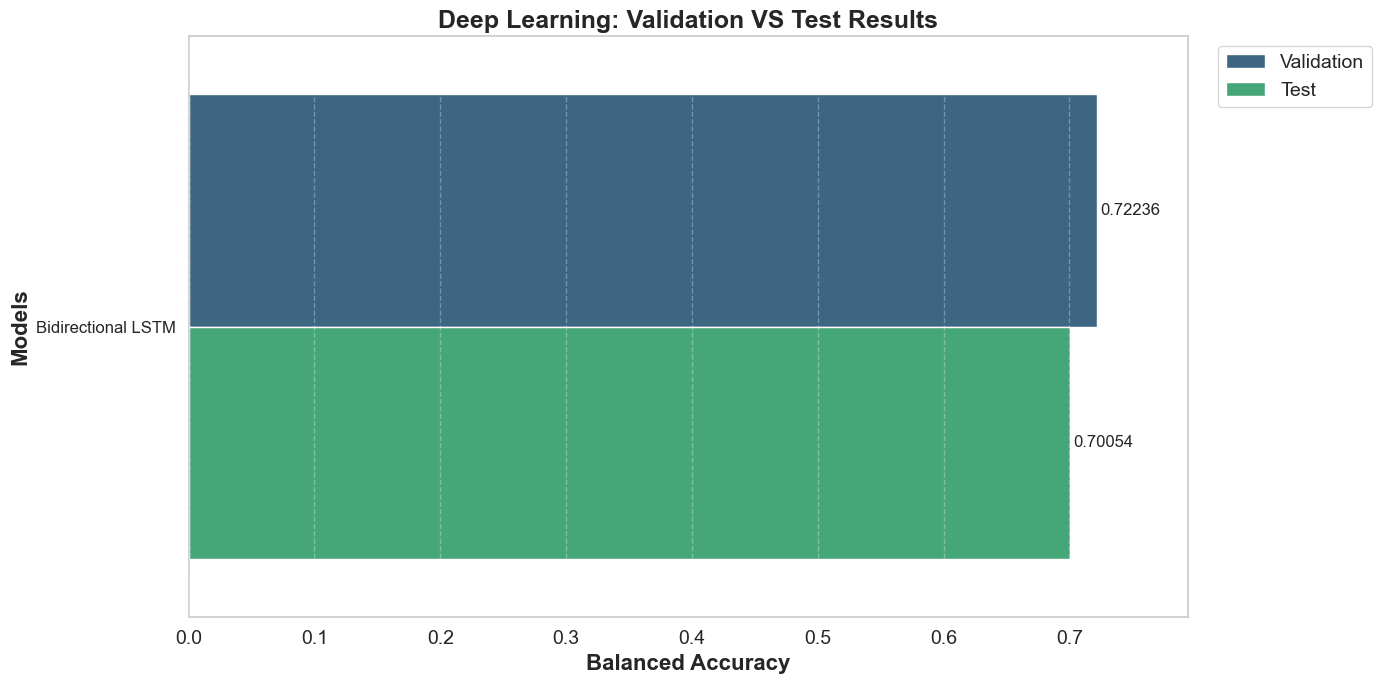

In [31]:
utils.plot_results_comparison(model_type_dl, results_val_per_type, results_test_per_type)

The model generalized well to the test set.

## 4.3 Transformers


In [32]:
model_type_transformer = "Transformers"
results_val_per_type[model_type_transformer] = {}
results_test_per_type[model_type_transformer] = {}

### 4.3.1 Bert


Transformer-based model, trained on English language, released in 2018 by Google.

Link: https://huggingface.co/google-bert/bert-base-uncased


Evaluating google-bert/bert-base-uncased on validation set...
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
google-bert/bert-base-uncased (fine-tuned)
----------------------------------------------------------------------------------------------------

Model found at models/google_bert_bert_base_uncased_fine_tuned. Loading saved model...

Trainable parameters: 109,484,547 / 109,484,547 (100.00%)
Model loaded. Skipping training and going directly to evaluation...
Training history loaded from: models/google_bert_bert_base_uncased_training_history.json
Plotting loaded training history...


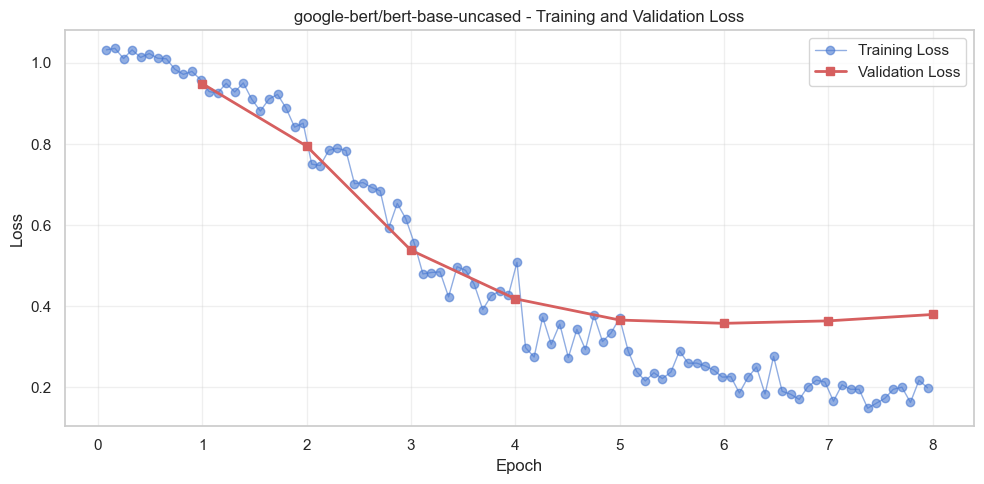

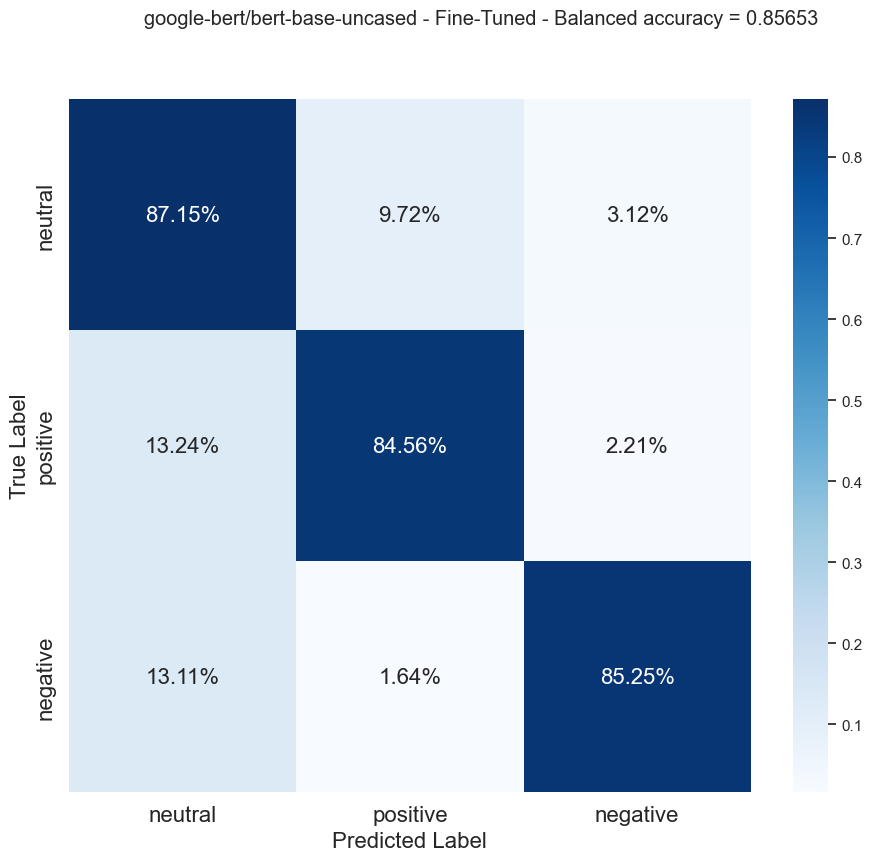


----------------------------------------------------------------------------------------------------
google-bert/bert-base-uncased Balanced Accuracy: 0.85653

----------------------------------------------------------------------------------------------------
Using google-bert/bert-base-uncased_fine_tuned for prediction...


/Users/bruno/ws/inf0619_final_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


File 'submissions/submission_google_bert_bert_base_uncased_fine_tuned.csv' generated successfully!
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


In [33]:
model_name_bert = "google-bert/bert-base-uncased"
trainer_bert = transformers.train_and_evaluate_model(
    model_name_bert, 
    model_type_transformer,
    df_train=df_fpb_train,
    df_val=df_fpb_val,
    df_test=df_fpb_test,
    y_train=y_train,
    y_val=y_val,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

The model shows a great improvement leap compared to classical models, reaching ~86% balanced accuracy.

Training begins to show slight signs of overfitting from the 6th epoch, indicating that it would benefit from hyperparameter tuning.

The confusion matrix demonstrates that the model has well-balanced results for all classes, with approximately ~85% for both positive and negative and ~88% for neutral. There is still some bias towards the neutral class: both negative and positive are confused with neutral ~13% of the time.

In [34]:
bert_ft_name = f"{model_name_bert} (fine-tuned)"
results_test[bert_ft_name] = 0.82422
results_test_per_type[model_type_transformer][bert_ft_name] = results_test[bert_ft_name]

Accuracy on test set (via Kaggle): **0.82422**


### 4.3.2 RoBERTa MNLI


Transformer-based model, trained on English language, released in August 2019 by Meta (then Facebook). MNLI version: Multi-Genre Natural Language Inference

Link: https://huggingface.co/FacebookAI/roberta-large-mnli



----------------------------------------------------------------------------------------------------
Evaluating: FacebookAI/roberta-large-mnli - zero-shot classification (pre-trained)
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps


Balanced Accuracy: 0.67972


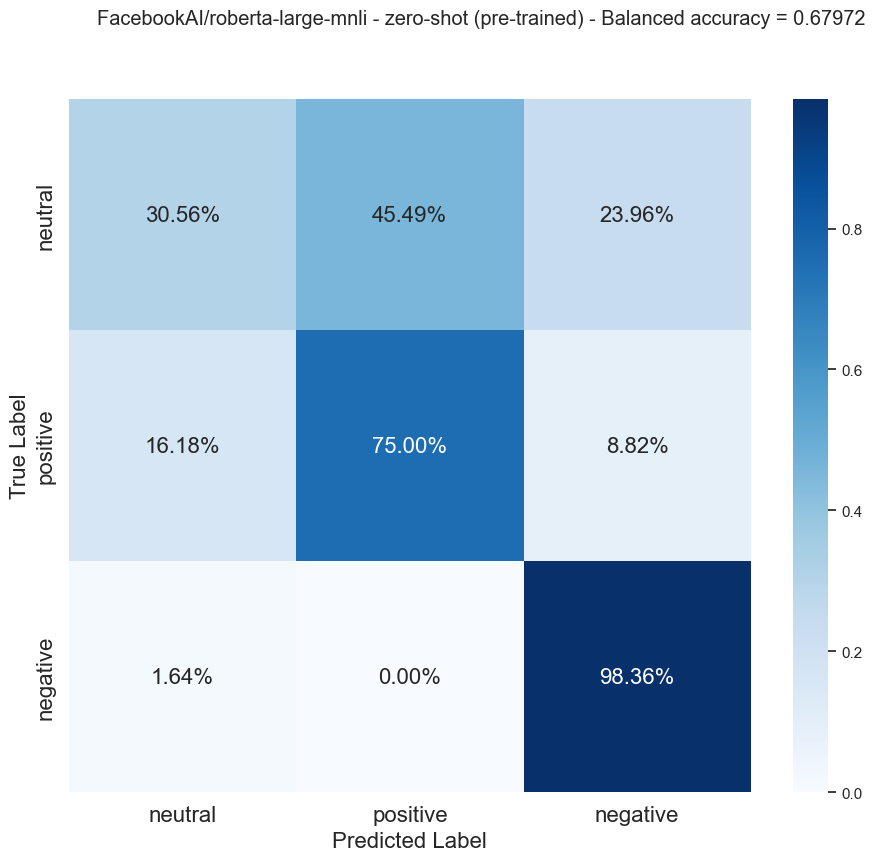

File 'submissions/submission_FacebookAI_roberta_large_mnli_zero_shot_pre_trained.csv' generated successfully!


In [35]:
model_name_roberta = "FacebookAI/roberta-large-mnli"
transformers.evaluate_zero_shot_model(
    model_name_roberta, 
    model_type_transformer,
    df_val=df_fpb_val,
    y_val=y_val,
    df_test=df_fpb_test,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

The pre-trained model showed modest performance, with approximately 68% balanced accuracy - slightly inferior to classical models.

It is interesting to note that the negative class performance was very high, ~98%, while the neutral class performance was very low, ~31%, confusing it with positive ~45% of the time.

In [36]:
roberta_zero_shot_name = f"{model_name_roberta} - zero-shot (pre-trained)"
results_test[roberta_zero_shot_name] = 0.68379
results_test_per_type[model_type_transformer][roberta_zero_shot_name] = results_test[
    roberta_zero_shot_name
]

Pre-trained model - accuracy on test set (via Kaggle): **0.68379**


Evaluating FacebookAI/roberta-large-mnli on validation set...
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
FacebookAI/roberta-large-mnli (fine-tuned)
----------------------------------------------------------------------------------------------------

Model found at models/FacebookAI_roberta_large_mnli_fine_tuned. Loading saved model...

Trainable parameters: 355,362,819 / 355,362,819 (100.00%)
Model loaded. Skipping training and going directly to evaluation...
Training history loaded from: models/FacebookAI_roberta_large_mnli_training_history.json
Plotting loaded training history...


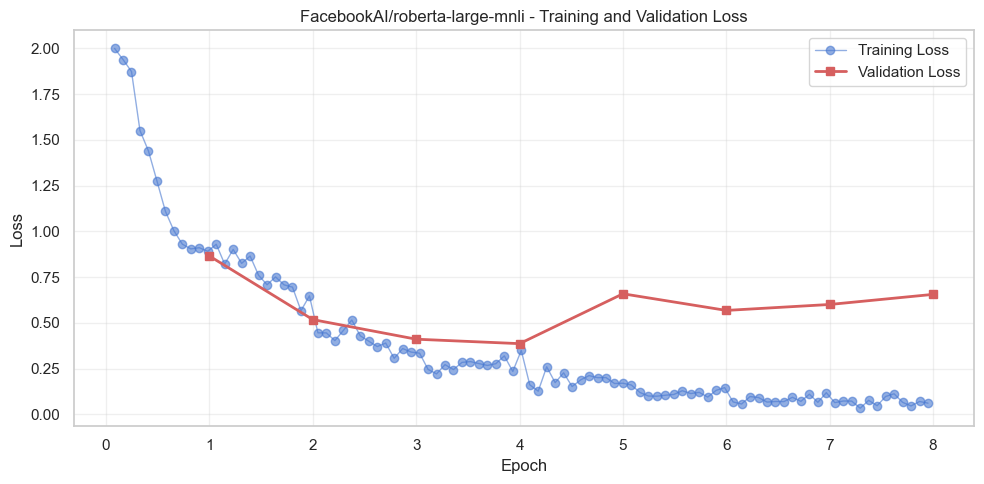

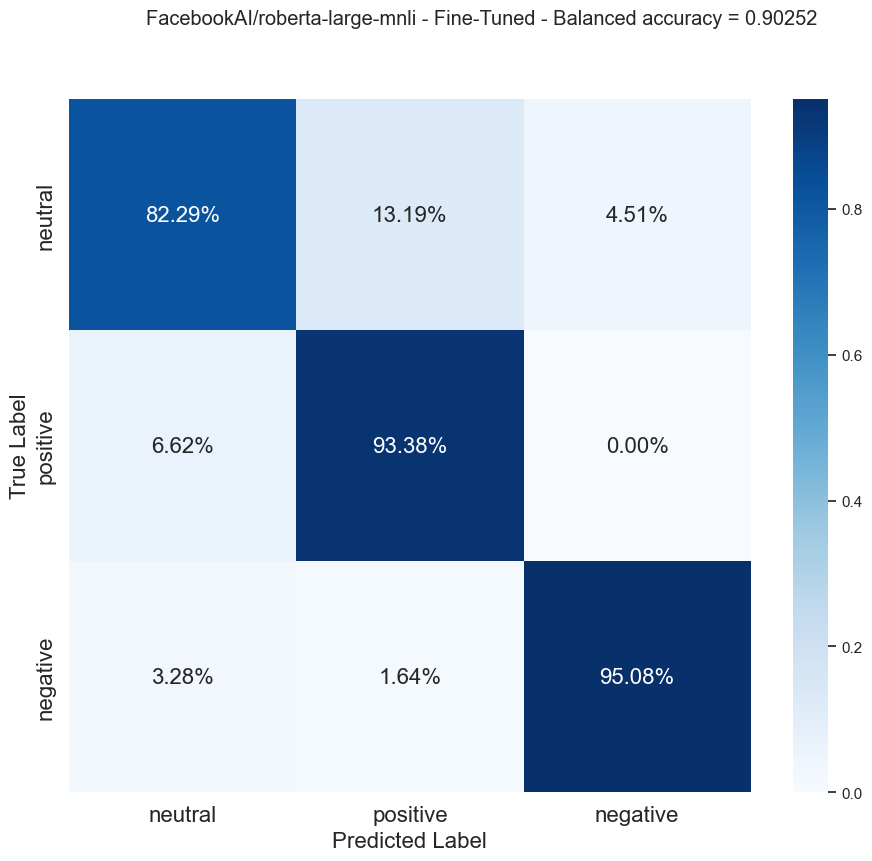


----------------------------------------------------------------------------------------------------
FacebookAI/roberta-large-mnli Balanced Accuracy: 0.90252

----------------------------------------------------------------------------------------------------
Using FacebookAI/roberta-large-mnli_fine_tuned for prediction...


/Users/bruno/ws/inf0619_final_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


File 'submissions/submission_FacebookAI_roberta_large_mnli_fine_tuned.csv' generated successfully!
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


In [37]:
trainer_roberta_large_mnli = transformers.train_and_evaluate_model(
    model_name_roberta,
    model_type_transformer,
    df_train=df_fpb_train,
    df_val=df_fpb_val,
    df_test=df_fpb_test,
    y_train=y_train,
    y_val=y_val,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

The fine-tuned model performance was excellent, reaching ~90% balanced accuracy.

Training begins to show signs of overfitting from the 5th epoch, indicating that it would benefit from hyperparameter tuning.

The confusion matrix demonstrates that the model has well-balanced results for all classes, with approximately ~93% for negative, ~94% for positive.

Accuracy for neutral is ~83%, confusing it with positive ~14% of the time.

It is interesting to note that the model does not confuse positive with negative, which is a good sign.

In [38]:
roberta_ft_name = f"{model_name_roberta} (fine-tuned)"
results_test[roberta_ft_name] = 0.89398
results_test_per_type[model_type_transformer][roberta_ft_name] = results_test[
    roberta_ft_name
]

Fine-tuned model - accuracy on test set (via Kaggle): **0.89398**


### 4.3.3 DeBERTa MNLI


Improvement over BERT and RoBERTa models with disentangled attention and improved masked decoder. MNLI version: Multi-Genre Natural Language Inference. Released by Microsoft in 2021.

Link: https://huggingface.co/microsoft/deberta-base-mnli



----------------------------------------------------------------------------------------------------
Evaluating: microsoft/deberta-base-mnli - zero-shot classification (pre-trained)
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at microsoft/deberta-base-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Balanced Accuracy: 0.61710


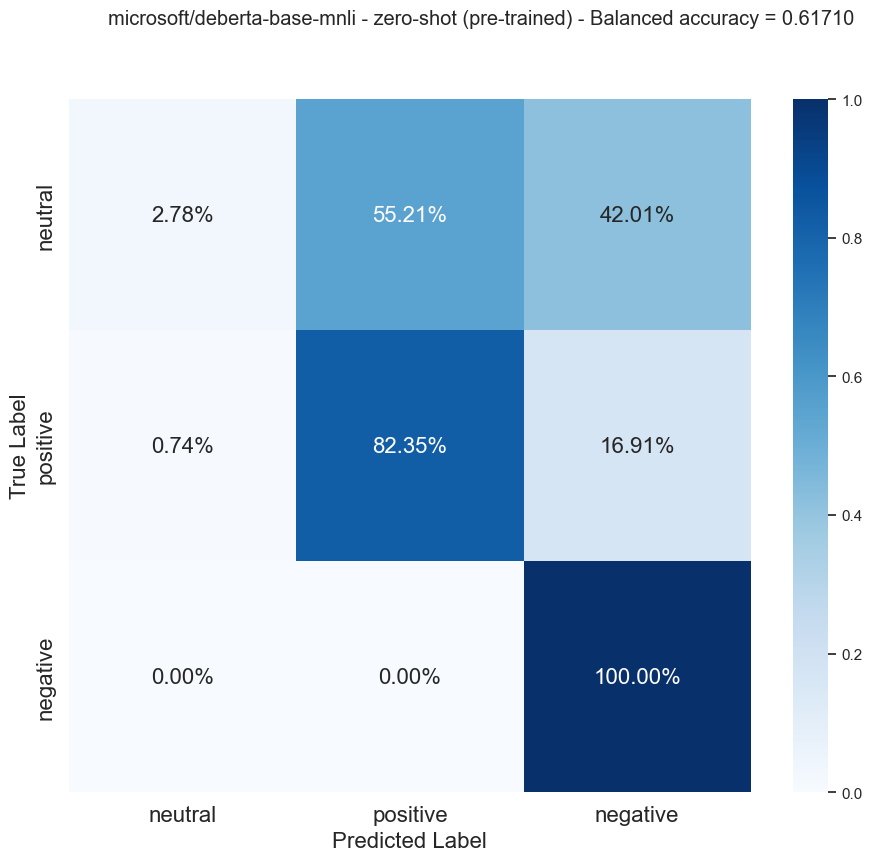

File 'submissions/submission_microsoft_deberta_base_mnli_zero_shot_pre_trained.csv' generated successfully!


In [39]:
model_name_deberta = "microsoft/deberta-base-mnli"
transformers.evaluate_zero_shot_model(
    model_name_deberta,
    model_type_transformer,
    df_val=df_fpb_val,
    y_val=y_val,
    df_test=df_fpb_test,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

In [40]:
deberta_zero_shot_name = f"{model_name_deberta} - zero-shot (pre-trained)"
results_test[deberta_zero_shot_name] = 0.64151
results_test_per_type[model_type_transformer][deberta_zero_shot_name] = results_test[
    deberta_zero_shot_name
]

The pre-trained model showed low performance, with approximately 62% balanced accuracy - inferior to classical models.

It shows optimal performance for the negative class: 100% accuracy. However, performance for the neutral class was very low, ~3%, which was confused with positive ~55% of the time and with negative ~42% of the time.

Pre-trained model - accuracy on test set (via Kaggle): **0.64151**


Evaluating microsoft/deberta-base-mnli on validation set...
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
microsoft/deberta-base-mnli (fine-tuned)
----------------------------------------------------------------------------------------------------

Model found at models/microsoft_deberta_base_mnli_fine_tuned. Loading saved model...

Trainable parameters: 139,194,627 / 139,194,627 (100.00%)
Model loaded. Skipping training and going directly to evaluation...
Training history loaded from: models/microsoft_deberta_base_mnli_training_history.json
Plotting loaded training history...


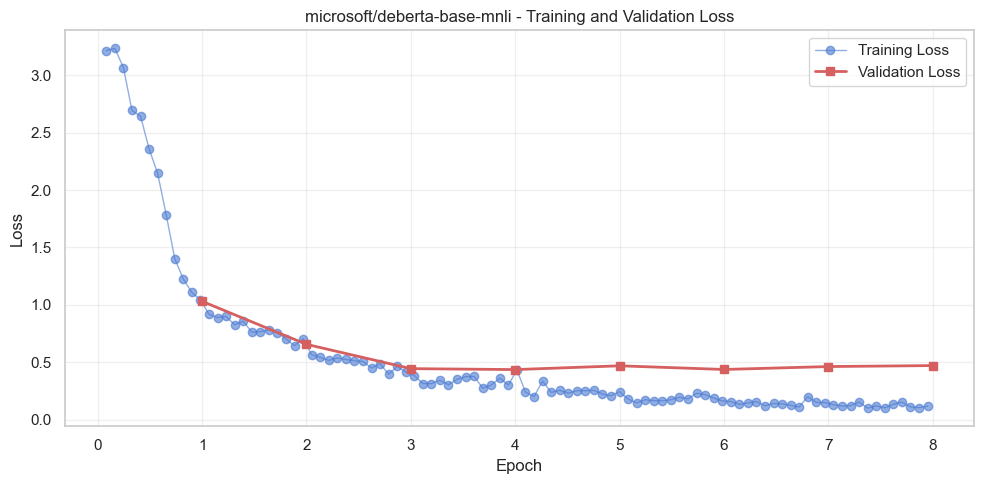

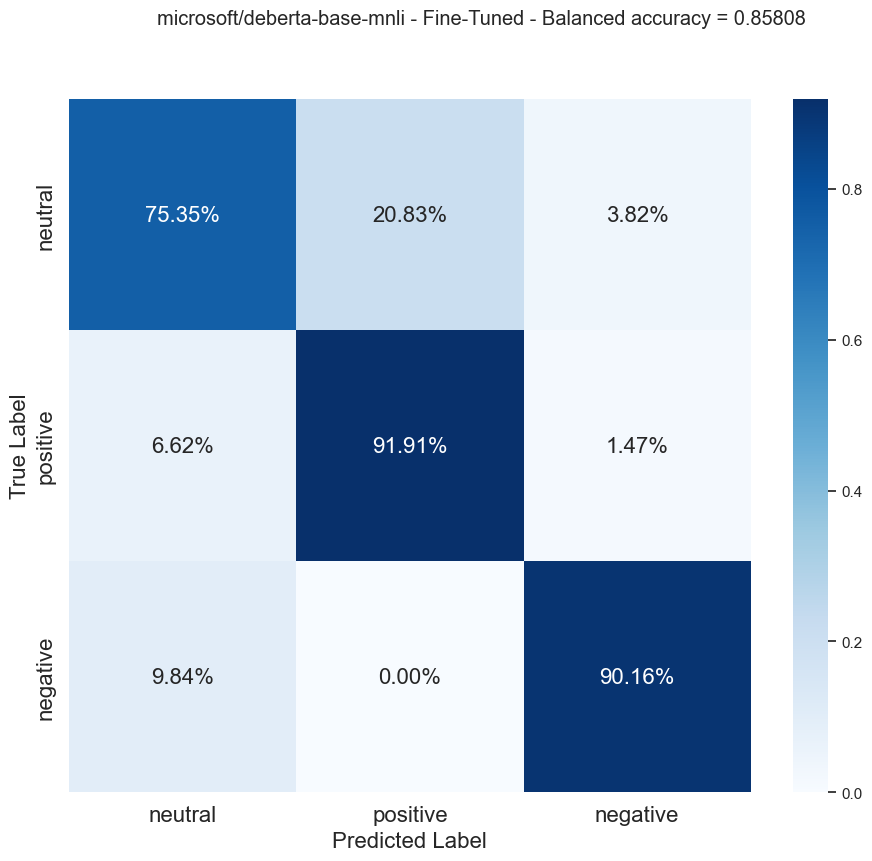


----------------------------------------------------------------------------------------------------
microsoft/deberta-base-mnli Balanced Accuracy: 0.85808

----------------------------------------------------------------------------------------------------
Using microsoft/deberta-base-mnli_fine_tuned for prediction...


/Users/bruno/ws/inf0619_final_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


File 'submissions/submission_microsoft_deberta_base_mnli_fine_tuned.csv' generated successfully!
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


In [41]:
trainer_deberta_base_mnli = transformers.train_and_evaluate_model(
    model_name_deberta,
    model_type_transformer,
    df_train=df_fpb_train,
    df_val=df_fpb_val,
    df_test=df_fpb_test,
    y_train=y_train,
    y_val=y_val,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

With fine-tuning, the model performance improves significantly to ~87%.

Training does not indicate major signs of overfitting.

The confusion matrix demonstrates performances above 90% for positive and negative. Neutral has the lowest performance, ~77%, confusing it with positive ~18% of the time.

In [42]:
deberta_ft_name = f"{model_name_deberta} (fine-tuned)"
results_test[deberta_ft_name] = 0.87804
results_test_per_type[model_type_transformer][deberta_ft_name] = results_test[
    deberta_ft_name
]

Fine-tuned model - accuracy on test set (via Kaggle): **0.87804**


### 4.3.4 FinBERT


FinBERT is a BERT model pre-trained on a large corpus of financial texts - the **TRC2** dataset (Thomson Reuters Text Research Collection). This allows it to understand the context and specific vocabulary of finance much better than generic models or models trained from scratch with little data. Released in 2019.

The model was pre-trained on the TRC2 dataset and fine-tuned on the same dataset we are using in this work. Therefore, we will evaluate the final version available on Hugging Face as a way to demonstrate the problems of evaluating using samples present in both training and test sets, since the risks of overfitting are extremely high.

Link: https://huggingface.co/ProsusAI/finbert



----------------------------------------------------------------------------------------------------
Evaluating: ProsusAI/finbert - sentiment-analysis (pre-trained)
----------------------------------------------------------------------------------------------------


Device set to use mps


Balanced Accuracy: 0.91391


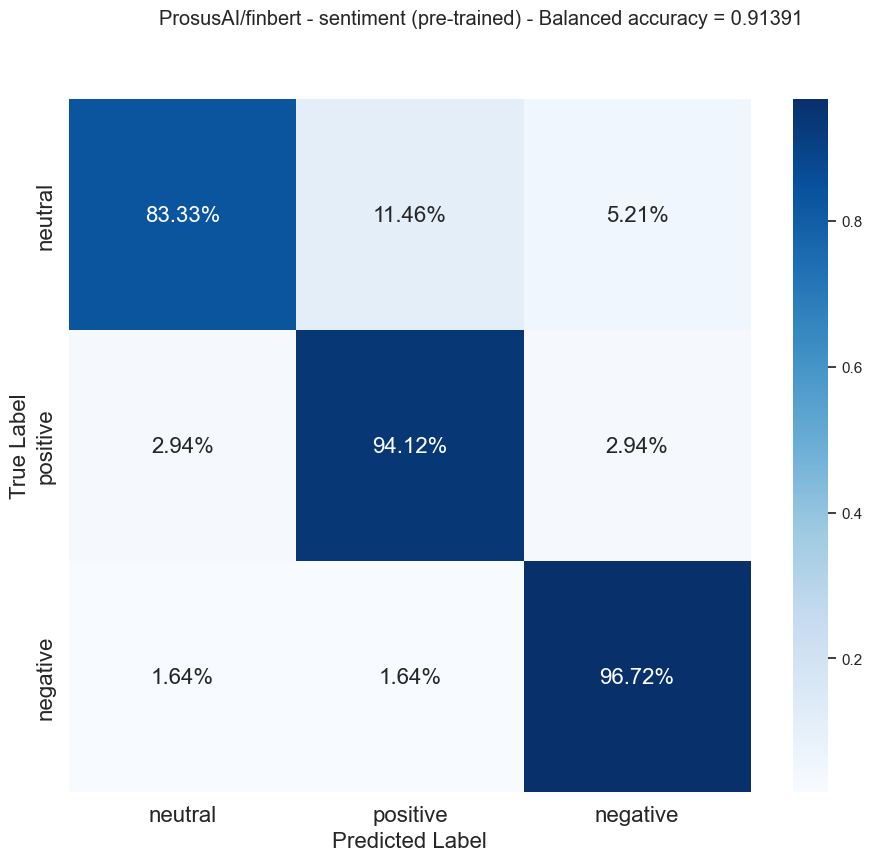

File 'submissions/submission_ProsusAI_finbert_sentiment_pre_trained.csv' generated successfully!


In [43]:
transformers.evaluate_sentiment_model(
    "ProsusAI/finbert",
    model_type_transformer,
    df_val=df_fpb_val,
    y_val=y_val,
    df_test=df_fpb_test,
    save_result=False,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

Pre-trained model - accuracy on test set (via Kaggle): **0.91716**


#### 4.3.4.1 FinbertTRC2

The `ProsusAI/finbert` model already comes fine-tuned on **Financial PhraseBank** but without guarantee that the train/validation/test splits of the dataset are the same as those available via Kaggle. Therefore, we will use the model pre-trained only on the **TRC2** dataset and perform fine-tuning with the splits from the Kaggle **Financial PhraseBank**, ensuring there are no sample repetitions between training and test splits.


In [44]:
# Download FinBERT trained on TRC2 dataset
utils.download_finbert_trc2_model()

File already exists and checksum verified: /Users/bruno/ws/inf0619_final_project/models/finbertTRC2/pytorch_model.bin


Evaluating models/finbertTRC2 on validation set...
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
models/finbertTRC2 (fine-tuned)
----------------------------------------------------------------------------------------------------

Model found at models/finbertTRC2_fine_tuned. Loading saved model...

Trainable parameters: 109,484,547 / 109,484,547 (100.00%)
Model loaded. Skipping training and going directly to evaluation...
Training history loaded from: models/models_finbertTRC2_training_history.json
Plotting loaded training history...


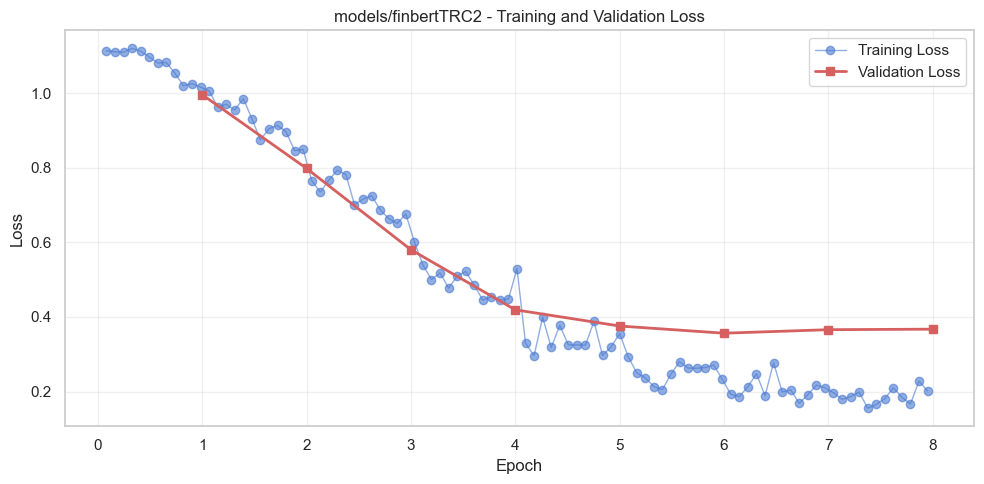

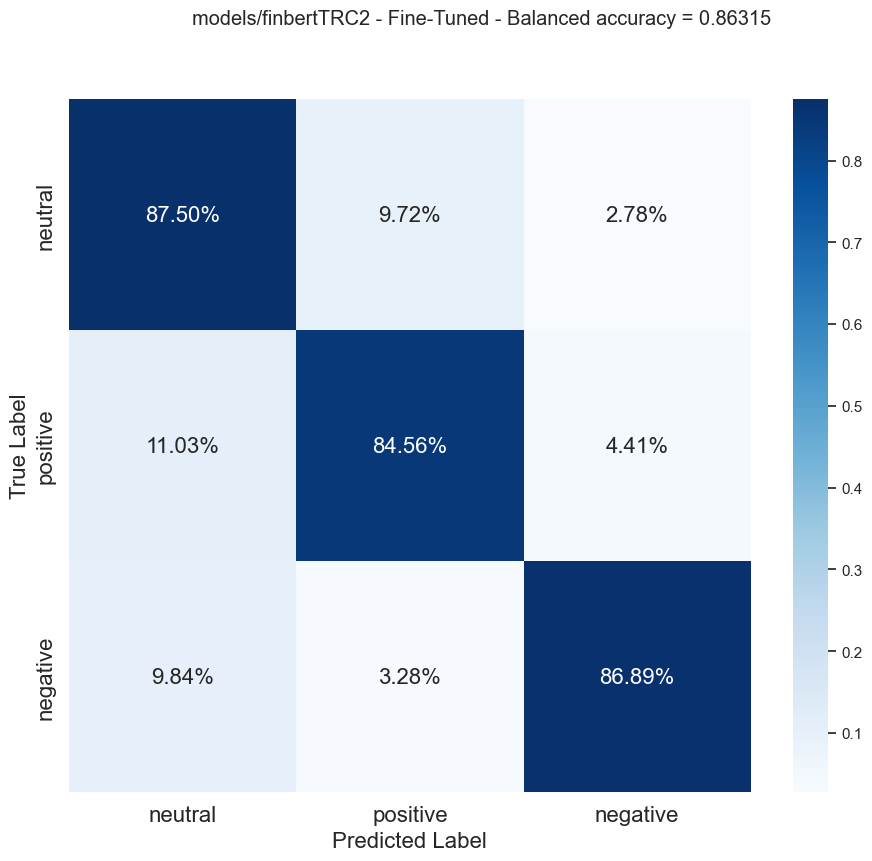


----------------------------------------------------------------------------------------------------
models/finbertTRC2 Balanced Accuracy: 0.86315

----------------------------------------------------------------------------------------------------
Using models/finbertTRC2_fine_tuned for prediction...


/Users/bruno/ws/inf0619_final_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


File 'submissions/submission_models_finbertTRC2_fine_tuned.csv' generated successfully!
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


In [45]:
model_name_finbert_trc2 = "models/finbertTRC2"
trainer_finbert_trc2_ft = transformers.train_and_evaluate_model(
    model_name_finbert_trc2,
    model_type_transformer,
    df_train=df_fpb_train,
    df_val=df_fpb_val,
    df_test=df_fpb_test,
    y_train=y_train,
    y_val=y_val,
    tokenizer_name="google-bert/bert-base-uncased",
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

In [46]:
finbert_trc2_ft_name = f"{model_name_finbert_trc2} (fine-tuned)"
results_test[finbert_trc2_ft_name] = 0.82000
results_test_per_type[model_type_transformer][finbert_trc2_ft_name] = results_test[
    finbert_trc2_ft_name
]

The fine-tuned base model (FinbertTRC2) had good performance, ~86%. However, it was more modest compared to the original pre-trained model.

Training did not indicate signs of overfitting. 

Performance is similar for all classes. Neutral: ~88%, positive: ~85% and negative: ~87%. Negative and positive are confused with neutral ~10% of the time each, and neutral is confused with positive ~10% of the time.

Accuracy on test set (via Kaggle): **0.82000**


### 4.3.5 Twitter RoBERTa Sentiment

RoBERTa-base model trained on a large amount of Twitter data, specialized in sentiment analysis. The question we want to answer is whether models trained for a specific task (sentiment analysis) on a more generic dataset perform well on a more specific dataset.

Link: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest



----------------------------------------------------------------------------------------------------
Evaluating: cardiffnlp/twitter-roberta-base-sentiment-latest - sentiment-analysis (pre-trained)
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps


Balanced Accuracy: 0.49627


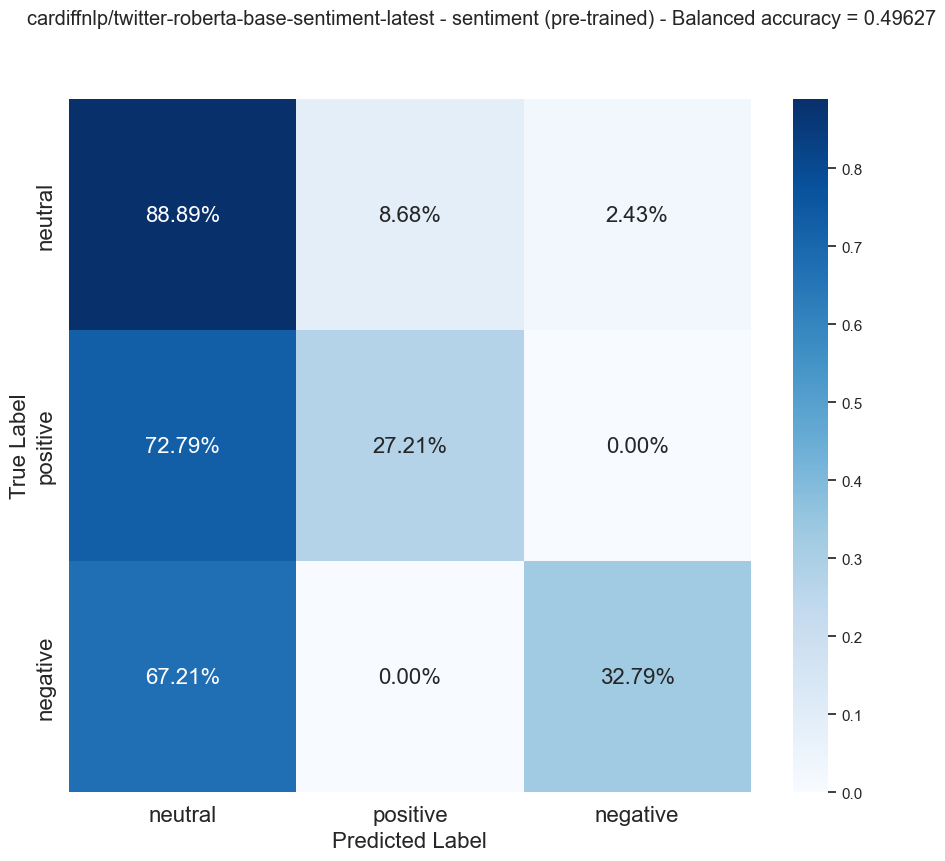

File 'submissions/submission_cardiffnlp_twitter_roberta_base_sentiment_latest_sentiment_pre_trained.csv' generated successfully!


In [47]:
model_name_twitter_roberta = "cardiffnlp/twitter-roberta-base-sentiment-latest"
transformers.evaluate_sentiment_model(
    model_name_twitter_roberta,
    model_type_transformer,
    df_val=df_fpb_val,
    y_val=y_val,
    df_test=df_fpb_test,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

In [48]:
twitter_roberta_name = f"{model_name_twitter_roberta} - sentiment (pre-trained)"
results_test[twitter_roberta_name] = 0.53730
results_test_per_type[model_type_transformer][twitter_roberta_name] = results_test[
    twitter_roberta_name
]

The pre-trained model showed poor performance: ~50% balanced accuracy, with high bias towards the neutral class, which indicates that evaluating a model trained on more generic data on a more specific dataset does not translate to good performance. In the next section we will evaluate fine-tuning the model on Financial PhraseBank.

Pre-trained model - accuracy on test set (via Kaggle): **0.53730**


Evaluating cardiffnlp/twitter-roberta-base-sentiment-latest on validation set...
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
cardiffnlp/twitter-roberta-base-sentiment-latest (fine-tuned)
----------------------------------------------------------------------------------------------------

Model found at models/cardiffnlp_twitter_roberta_base_sentiment_latest_fine_tuned. Loading saved model...

Trainable parameters: 124,647,939 / 124,647,939 (100.00%)
Model loaded. Skipping training and going directly to evaluation...
Training history loaded from: models/cardiffnlp_twitter_roberta_base_sentiment_latest_training_history.json
Plotting loaded training history...


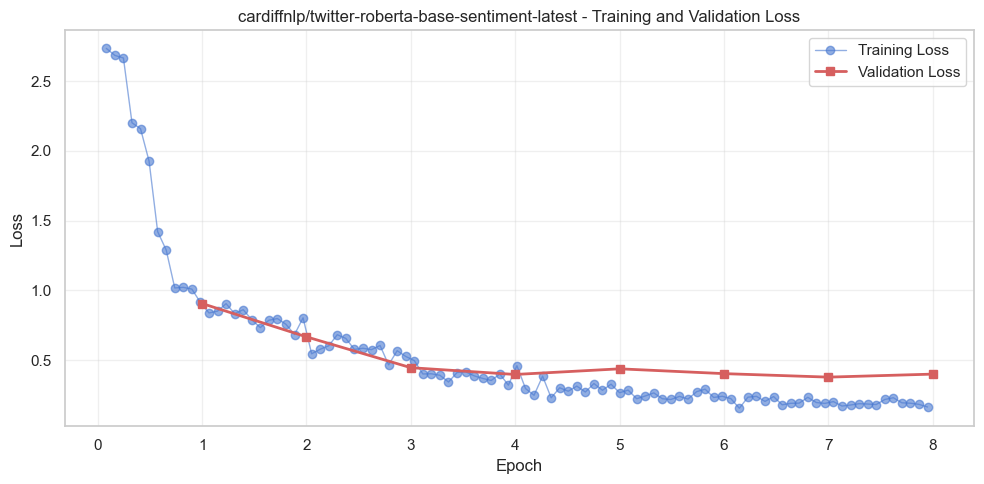

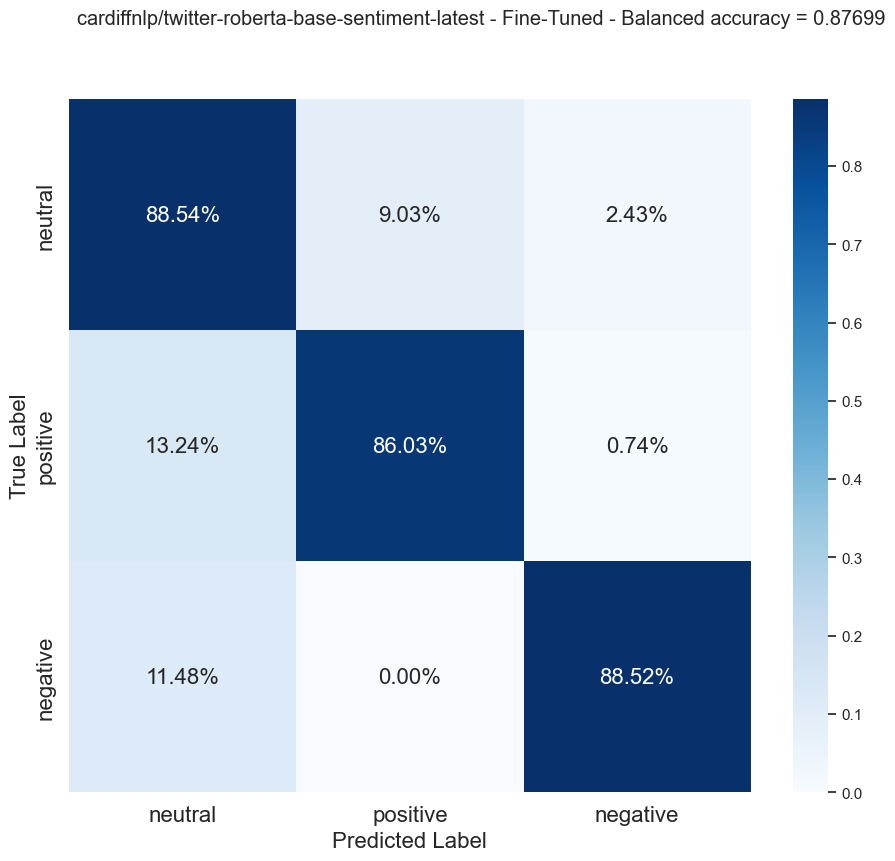


----------------------------------------------------------------------------------------------------
cardiffnlp/twitter-roberta-base-sentiment-latest Balanced Accuracy: 0.87699

----------------------------------------------------------------------------------------------------
Using cardiffnlp/twitter-roberta-base-sentiment-latest_fine_tuned for prediction...


/Users/bruno/ws/inf0619_final_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


File 'submissions/submission_cardiffnlp_twitter_roberta_base_sentiment_latest_fine_tuned.csv' generated successfully!
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


In [49]:
trainer_twitter_roberta_base_sentiment = transformers.train_and_evaluate_model(
    model_name_twitter_roberta,
    model_type_transformer,
    df_train=df_fpb_train,
    df_val=df_fpb_val,
    df_test=df_fpb_test,
    y_train=y_train,
    y_val=y_val,
    results_val=results_val,
    results_val_per_type=results_val_per_type,
)

In [50]:
roberta_ft_name = f"{model_name_twitter_roberta} (fine-tuned)"
results_test[roberta_ft_name] = 0.87754
results_test_per_type[model_type_transformer][roberta_ft_name] = results_test[
    roberta_ft_name
]

With fine-tuning, the model showed an incredible performance leap, reaching ~88% balanced accuracy, demonstrating the power of transfer learning.

Training did not show signs of overfitting.

There is still some bias towards the neutral class: positive and negative classes are confused with neutral ~10% of the time. In addition, the neutral class is confused with positive ~9% of the time.

Model with fine-tuning - accuracy on test set (via Kaggle): **0.87754**


### Results Comparison - validation vs test


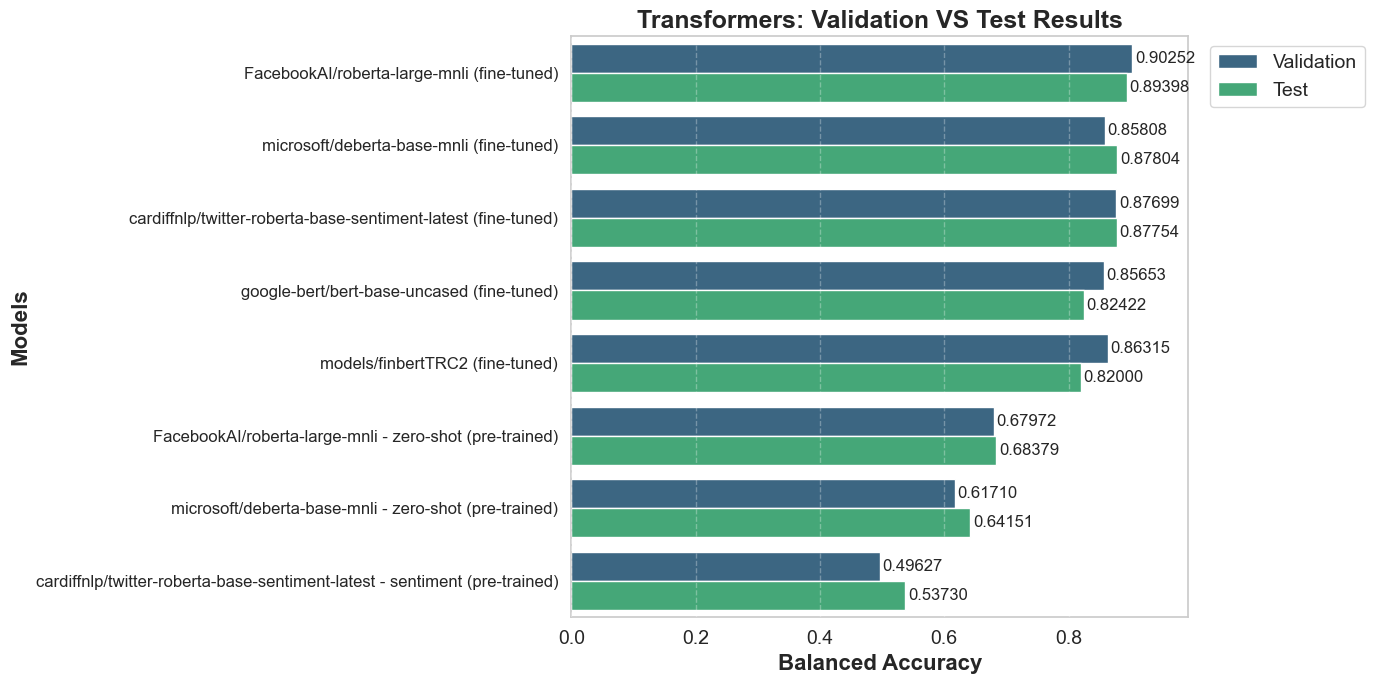

In [51]:
utils.plot_results_comparison(model_type_transformer, results_val_per_type, results_test_per_type)

Pre-trained models showed slightly better performance on the test set than on validation.

Fine-tuned models showed slightly worse, but still similar, performance on the test set.

It can be said that all models generalize well.

In [52]:
best_model_transformer_val = max(
    results_val_per_type[model_type_transformer],
    key=results_val_per_type[model_type_transformer].get,
)
print(f"Best Transformer model (validation): {best_model_transformer_val}")
print(
    f"  Accuracy: {results_val_per_type[model_type_transformer][best_model_transformer_val]:.5f}"
)

best_model_transformer_test = max(
    results_test_per_type[model_type_transformer],
    key=results_test_per_type[model_type_transformer].get,
)
print(f"\nBest Transformer model (test): {best_model_transformer_test}")
print(
    f"  Accuracy: {results_test_per_type[model_type_transformer][best_model_transformer_test]:.5f}"
)

Best Transformer model (validation): FacebookAI/roberta-large-mnli (fine-tuned)
  Accuracy: 0.90252

Best Transformer model (test): FacebookAI/roberta-large-mnli (fine-tuned)
  Accuracy: 0.89398


## 4.4 LLMs


In [53]:
model_type_llm = "LLMs"
results_val_per_type[model_type_llm] = {}
results_test_per_type[model_type_llm] = {}

### 4.4.1 NOSIBLE Financial Sentiment v1.1


Local model (0.6B parameters) trained by NOSIBLE, based on Qwen from Chinese company Alibaba. Pre-trained on a large dataset of financial news, which was annotated in parts by humans and in parts by LLMs.

Link: https://huggingface.co/NOSIBLE/financial-sentiment-v1.1-base

Evaluating model: NOSIBLE/financial-sentiment-v1.1-base
Evaluating 485 samples...


Processing validation texts: 100%|██████████| 485/485 [00:30<00:00, 15.99it/s]


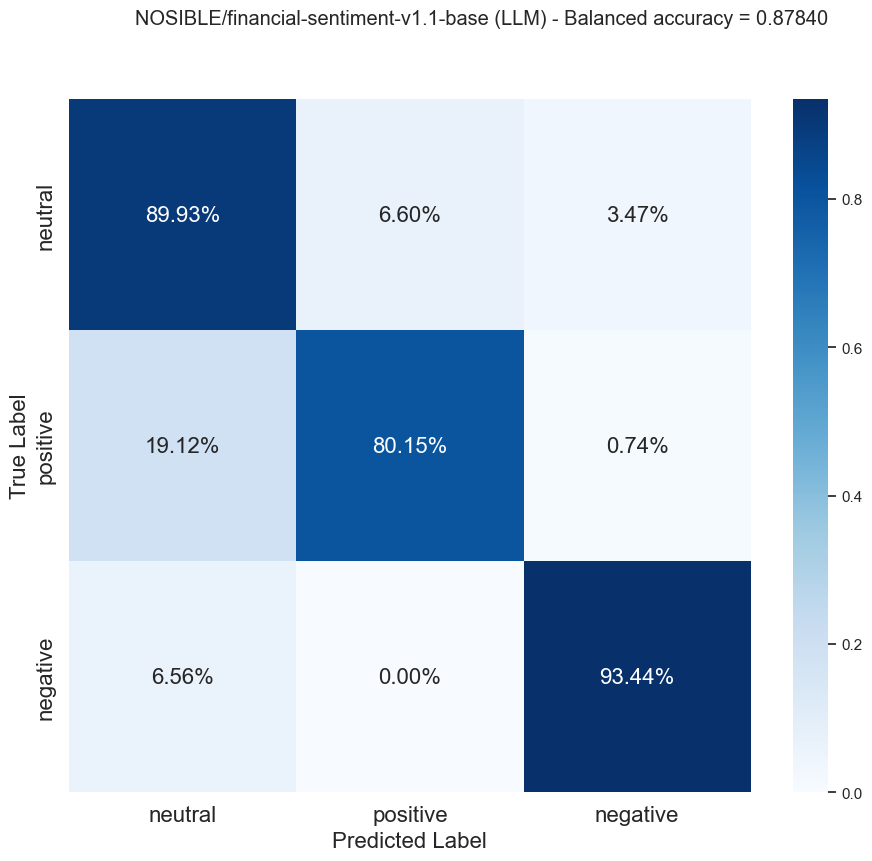

----------------------------------------------------------------------------------------------------
NOSIBLE/financial-sentiment-v1.1-base (LLM) Balanced Accuracy: 0.87840
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Evaluating on test set...
----------------------------------------------------------------------------------------------------
Evaluating model: NOSIBLE/financial-sentiment-v1.1-base
Evaluating 485 samples...


Processing test texts: 100%|██████████| 485/485 [00:27<00:00, 17.57it/s]

File 'submission_NOSIBLE_financial_sentiment_v1.1_base.csv' generated successfully!
NOSIBLE/financial-sentiment-v1.1-base Balanced Accuracy: 0.87840


In [54]:
model_name_finsent = "NOSIBLE/financial-sentiment-v1.1-base"
result_name_finsent = f"{model_name_finsent} (LLM)"

balanced_acc_finsent, predictions_finsent = llm.evaluate_llm(
    model_name_finsent, df_fpb_val, y_val
)
print("-" * 100)
print(f"{result_name_finsent} Balanced Accuracy: {balanced_acc_finsent:.5f}")
print("-" * 100)
results_val[result_name_finsent] = balanced_acc_finsent
results_val_per_type[model_type_llm][result_name_finsent] = balanced_acc_finsent

print("-" * 100)
print("Evaluating on test set...")
print("-" * 100)

_, predictions_finsent_test = llm.evaluate_llm(
    model_name_finsent, df_fpb_test, y=None
)
print(f"{model_name_finsent} Balanced Accuracy: {balanced_acc_finsent:.5f}")

The model showed excellent results, reaching ~88% balanced accuracy.

The confusion matrix indicates that positive samples were correctly classified ~93% of the time and never confused with the negative class.

The neutral class also shows good performance: ~90%.

The positive class had the worst performance: ~80%, being confused with neutral ~19% of the time.

In [55]:
results_test[result_name_finsent] = 0.79866
results_test_per_type[model_type_llm][result_name_finsent] = results_test[
    result_name_finsent
]

Accuracy on test set (via Kaggle): **0.79866**


### 4.4.2 Meta Llama 3.2


Released in September 2024 by Meta. Model with 1B parameters. Optimized for instruction tasks in multilingual contexts.

Link: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct


Evaluating model: meta-llama/Llama-3.2-1B-Instruct
Evaluating 485 samples...


Processing validation texts: 100%|██████████| 485/485 [00:26<00:00, 18.46it/s]


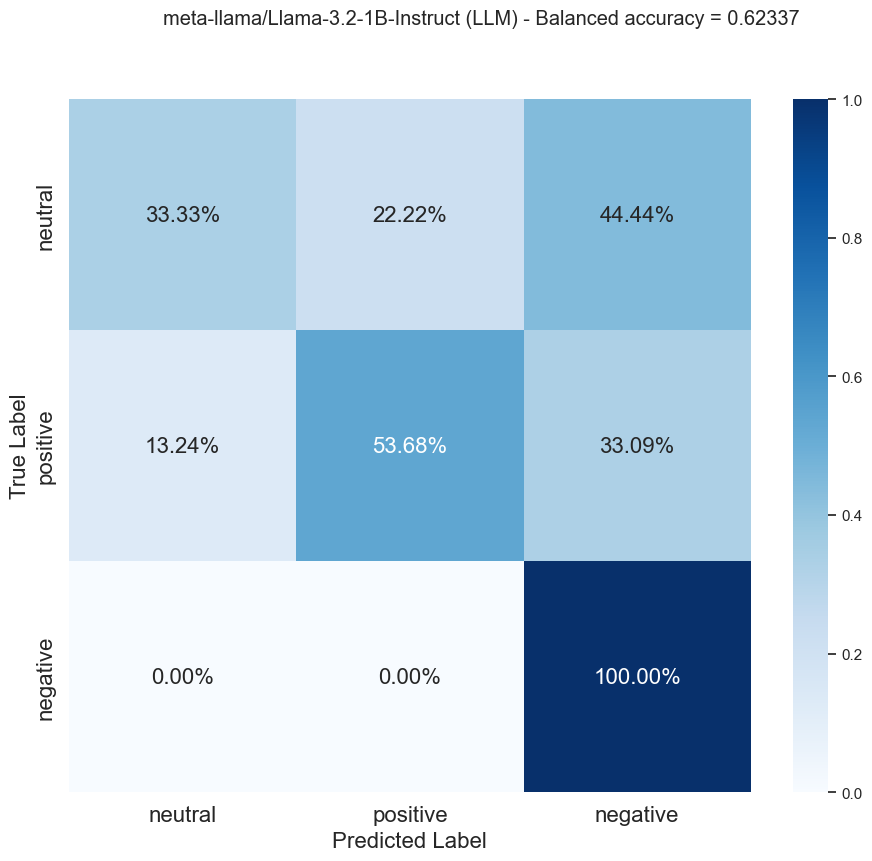

----------------------------------------------------------------------------------------------------
meta-llama/Llama-3.2-1B-Instruct Balanced Accuracy: 0.62337
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Evaluating on test set...
----------------------------------------------------------------------------------------------------
Evaluating model: meta-llama/Llama-3.2-1B-Instruct
Evaluating 485 samples...


Processing test texts: 100%|██████████| 485/485 [00:24<00:00, 19.51it/s]

File 'submission_meta_llama_Llama_3.2_1B_Instruct.csv' generated successfully!
meta-llama/Llama-3.2-1B-Instruct Balanced Accuracy: 0.62337


In [56]:
from huggingface_hub import login

# Before running, obtain a Hugging Face token with access to the model and save the HUGGINGFACE_HUB_TOKEN environment variable with the command:
# export HUGGINGFACE_HUB_TOKEN=<your_token>
# or pass the token directly to the login function
HUGGINGFACE_HUB_TOKEN = os.getenv("HUGGINGFACE_HUB_TOKEN")
login(HUGGINGFACE_HUB_TOKEN)

# Load model
model_name_llama = "meta-llama/Llama-3.2-1B-Instruct"
result_name_llama = f"{model_name_llama} (LLM)"

balanced_acc_llama, predictions_llama = llm.evaluate_llm(
    model_name_llama, df_fpb_val, y_val
)
print("-" * 100)
print(f"{model_name_llama} Balanced Accuracy: {balanced_acc_llama:.5f}")
print("-" * 100)
results_val[result_name_llama] = balanced_acc_llama
results_val_per_type[model_type_llm][result_name_llama] = balanced_acc_llama

print("-" * 100)
print("Evaluating on test set...")
print("-" * 100)

_, predictions_llama_test = llm.evaluate_llm(
    model_name_llama, df_fpb_test, y=None
)
print(f"{model_name_llama} Balanced Accuracy: {balanced_acc_llama:.5f}")

The model had low performance, ~62%.

The confusion matrix demonstrates bias towards the negative class, which achieved 100% accuracy. Positive errs to negative ~33% of the time and neutral errs to negative ~44% of the time.

In [57]:
results_test[result_name_llama] = 0.60421
results_test_per_type[model_type_llm][result_name_llama] = results_test[
    result_name_llama
]

Accuracy on test set (via Kaggle): **0.60421**


### 4.4.3 Google Gemma 3


Released in 2025 by Google, in a way as a response to Meta's Llama. Model with 1B parameters. Optimized for instruction tasks in multilingual contexts.

Link: https://huggingface.co/google/gemma-3-1b-it


Evaluating model: google/gemma-3-1b-it
Evaluating 485 samples...


Processing validation texts: 100%|██████████| 485/485 [00:43<00:00, 11.24it/s]


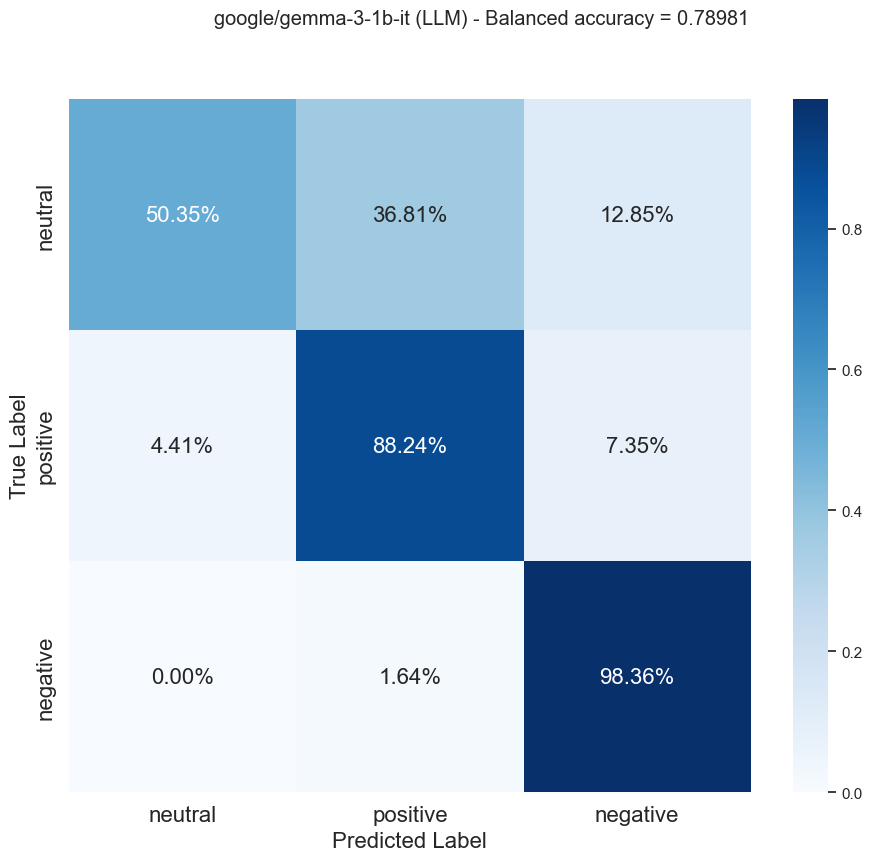

----------------------------------------------------------------------------------------------------
google/gemma-3-1b-it Balanced Accuracy: 0.78981
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Evaluating on test set...
----------------------------------------------------------------------------------------------------
Evaluating model: google/gemma-3-1b-it
Evaluating 485 samples...


Processing test texts: 100%|██████████| 485/485 [00:40<00:00, 12.07it/s]

File 'submission_google_gemma_3_1b_it.csv' generated successfully!
google/gemma-3-1b-it Balanced Accuracy: 0.78981


In [58]:
from huggingface_hub import login

# Before running, obtain a Hugging Face token with access to the model and save the HUGGINGFACE_HUB_TOKEN environment variable with the command:
# export HUGGINGFACE_HUB_TOKEN=<your_token>
# or pass the token directly to the login function
HUGGINGFACE_HUB_TOKEN = os.getenv("HUGGINGFACE_HUB_TOKEN")
login(HUGGINGFACE_HUB_TOKEN)

# Load model
model_name_gemma = "google/gemma-3-1b-it"
result_name_gemma = f"{model_name_gemma} (LLM)"

balanced_acc_gemma, predictions_gemma = llm.evaluate_llm(
    model_name_gemma, df_fpb_val, y_val
)
print("-" * 100)
print(f"{model_name_gemma} Balanced Accuracy: {balanced_acc_gemma:.5f}")
print("-" * 100)
results_val[result_name_gemma] = balanced_acc_gemma
results_val_per_type[model_type_llm][result_name_gemma] = balanced_acc_gemma

print("-" * 100)
print("Evaluating on test set...")
print("-" * 100)

_, predictions_gemma_test = llm.evaluate_llm(
    model_name_gemma, df_fpb_test, y=None
)
print(f"{model_name_gemma} Balanced Accuracy: {balanced_acc_gemma:.5f}")

In [59]:
results_test[result_name_gemma] = 0.75503
results_test_per_type[model_type_llm][result_name_gemma] = results_test[
    result_name_gemma
]

The model had performance slightly superior to classical models, but still far from transformers: ~79%.

Notable ~98% accuracy for the negative class and only ~50% accuracy for the neutral class, which is confused with positive 37% of the time.

Accuracy on test set (via Kaggle): **0.75503**


### 4.4.4 ChatGPT - GPT-5.2


ChatGPT is probably the most popular LLM application. We evaluated GPT version 5.2. Released in December 2025.

Link: https://platform.openai.com/docs/guides/latest-model

In [60]:
%pip install openai

Note: you may need to restart the kernel to use updated packages.


----------------------------------------------------------------------------------------------------
Evaluating on validation set...
----------------------------------------------------------------------------------------------------
Evaluating model: gpt-5.2
Evaluating 485 samples...


Processing validation texts: 100%|██████████| 485/485 [10:40<00:00,  1.32s/it]


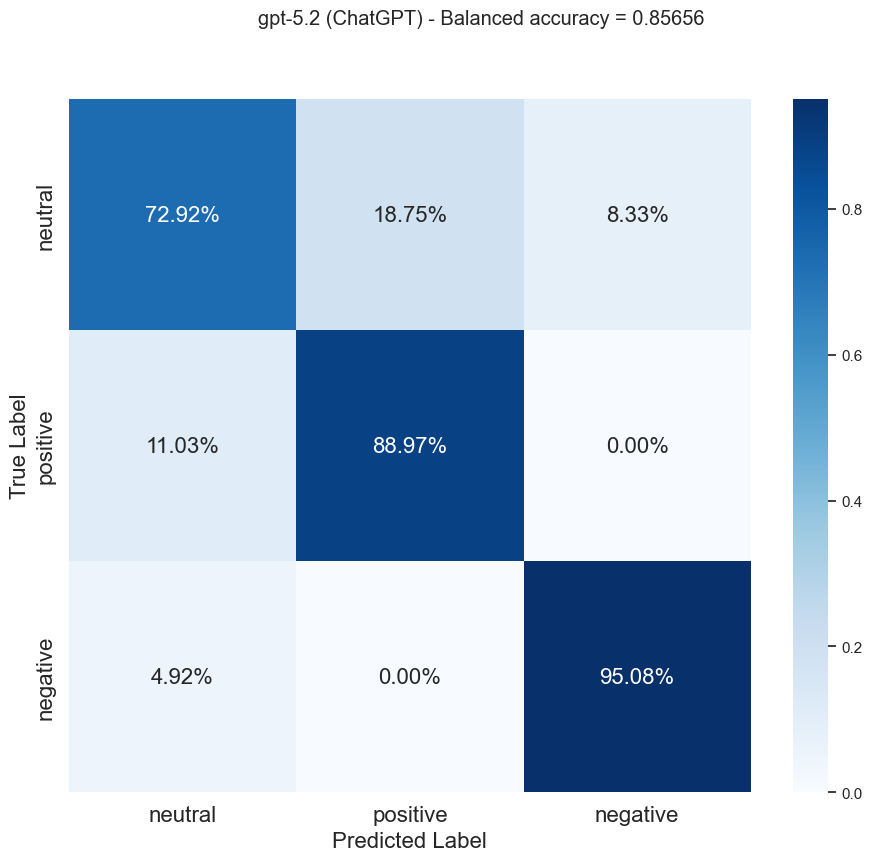

----------------------------------------------------------------------------------------------------
Generating submission for test set...
----------------------------------------------------------------------------------------------------
Evaluating model: gpt-5.2
Evaluating 485 samples...


Processing test texts: 100%|██████████| 485/485 [10:24<00:00,  1.29s/it]

File 'submissions/submission_chatgpt_gpt_5.2.csv' generated successfully!


In [61]:
# Create submission for test set using ChatGPT
model_name_chatgpt = "gpt-5.2"
result_name_chatgpt = f"ChatGPT {model_name_chatgpt} (LLM)"

print("-" * 100)
print("Evaluating on validation set...")
print("-" * 100)

balanced_acc_chatgpt, _ = llm.evaluate_chatgpt(model_name_chatgpt, df_fpb_val, y_val)
results_val[result_name_chatgpt] = balanced_acc_chatgpt
results_val_per_type[model_type_llm][result_name_chatgpt] = balanced_acc_chatgpt

print("-" * 100)
print("Generating submission for test set...")
print("-" * 100)

_, _ = llm.evaluate_chatgpt(model_name_chatgpt, df_fpb_test, y=None)

The model had results similar to BERT with fine-tuning: ~86%.

Notable performance for the negative class, ~95% never confused with the positive class.

Also notable is the modest performance of the neutral class, ~73%, confused with positive ~19% of the time.

In [83]:
results_test[result_name_chatgpt] = 0.85799
results_test_per_type[model_type_llm][result_name_chatgpt] = results_test[result_name_chatgpt]

Accuracy on test set (via Kaggle): **0.85074**

### Results Comparison - validation vs test

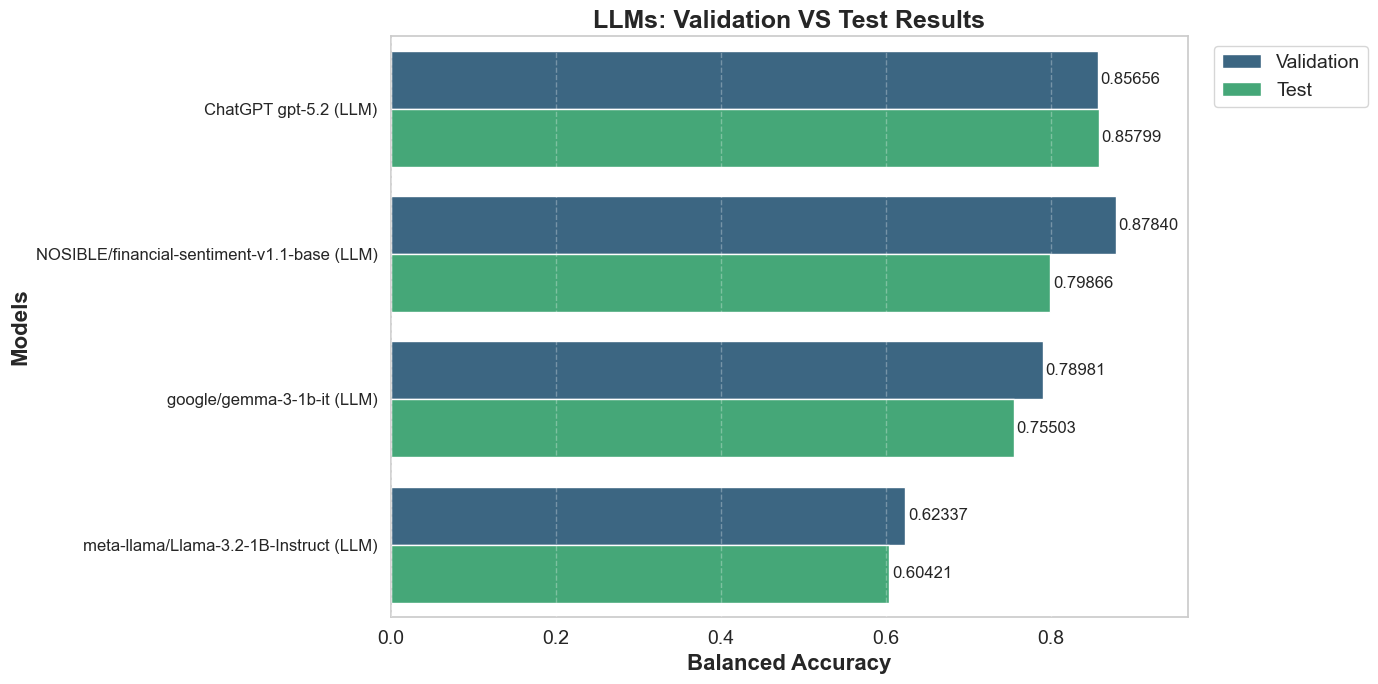

In [84]:
utils.plot_results_comparison(model_type_llm, results_val_per_type, results_test_per_type)

Overall, the models show similar performance on validation and test sets.

The exception is Financial Sentiment, which was 5% worse on test - indicating some weakness in generalization capacity - potentially originating from the automatic annotation of a large portion of the dataset on which it was pre-trained.

In [85]:
best_model_llm_val = max(
    results_val_per_type[model_type_llm],
    key=results_val_per_type[model_type_llm].get,
)
print(f"Best LLM model (validation): {best_model_llm_val}")
print(f"  Accuracy: {results_val_per_type[model_type_llm][best_model_llm_val]:.5f}")

best_model_llm_test = max(
    results_test_per_type[model_type_llm],
    key=results_test_per_type[model_type_llm].get,
)
print(f"\nBest LLM model (test): {best_model_llm_test}")
print(f"  Accuracy: {results_test_per_type[model_type_llm][best_model_llm_test]:.5f}")

Best LLM model (validation): NOSIBLE/financial-sentiment-v1.1-base (LLM)
  Accuracy: 0.87840

Best LLM model (test): ChatGPT gpt-5.2 (LLM)
  Accuracy: 0.85799


## 5. Evaluation and Results Comparison

We will visualize which model had the best performance, comparing all models.


### Helper Functions


In [86]:
# Create dictionaries with the best results of each model
best_results_val = {}
best_results_test = {}

keys = list(results_val_per_type.keys())

for model_type in keys:
    model_name_val = max(
        results_val_per_type[model_type], key=results_val_per_type[model_type].get
    )
    model_name_test = max(
        results_test_per_type[model_type], key=results_test_per_type[model_type].get
    )
    best_results_val[model_name_val] = results_val[model_name_val]
    best_results_test[model_name_test] = results_test[model_name_test]

In [87]:
result_type_name = "Best Results"

best_results_val_per_type = {}
best_results_test_per_type = {}

best_results_val_per_type[result_type_name] = {}
best_results_test_per_type[result_type_name] = {}

keys = list(results_val_per_type.keys())

for model_type in keys:
    model_name_val = max(
        results_val_per_type[model_type], key=results_val_per_type[model_type].get
    )
    best_results_val_per_type[result_type_name][model_type] = results_val_per_type[
        model_type
    ][model_name_val]

    model_name_test = max(
        results_test_per_type[model_type], key=results_test_per_type[model_type].get
    )
    best_results_test_per_type[result_type_name][model_type] = results_test_per_type[
        model_type
    ][model_name_test]

In [88]:
def display_best_results(results):
    display(
        pd.DataFrame(
            [
                {
                    "Model": k,
                    "Balanced Accuracy (validation)": results[k],
                }
                for k in results.keys()
            ]
        )
        .sort_values(by="Balanced Accuracy (validation)", ascending=False)
        .reset_index(drop=True)
    )

#### Best Results


In [89]:
print("Best Results - Validation")
display_best_results(best_results_val)

print("Best Results - Test")
display_best_results(best_results_test)

Best Results - Validation


Model  Balanced Accuracy (validation)
0   FacebookAI/roberta-large-mnli (fine-tuned)                        0.902520
1  NOSIBLE/financial-sentiment-v1.1-base (LLM)                        0.878401
2                                    SVM Tuned                        0.737556
3                           Bidirectional LSTM                        0.722360

Best Results - Test


Model  Balanced Accuracy (validation)
0  FacebookAI/roberta-large-mnli (fine-tuned)                         0.89398
1                       ChatGPT gpt-5.2 (LLM)                         0.85799
2                                   SVM Tuned                         0.70781
3                          Bidirectional LSTM                         0.70054

It is important to note that the best LLMs in validation and test are different. In validation the best LLM was `NOSIBLE/financial-sentiment-v1.1-base` and in test the best was `ChatGPT gpt-5.2`. This was considered in the graph below.


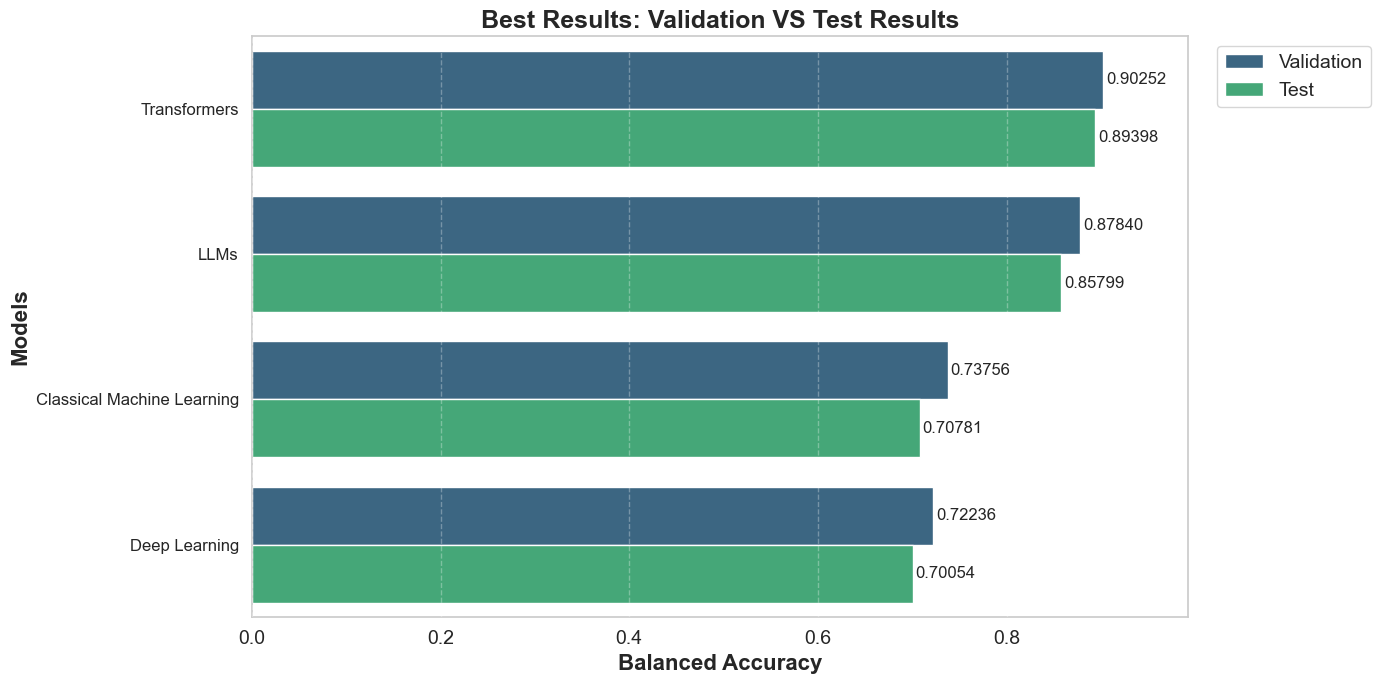

In [90]:
utils.plot_results_comparison(
    result_type_name, best_results_val_per_type, best_results_test_per_type
)

### All Results


/var/folders/6z/x30k7lfx3s14wgz7gd9kb3yh0000gn/T/ipykernel_24972/1971073291.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Balanced Accuracy", y="Model", data=res_df, palette="viridis")


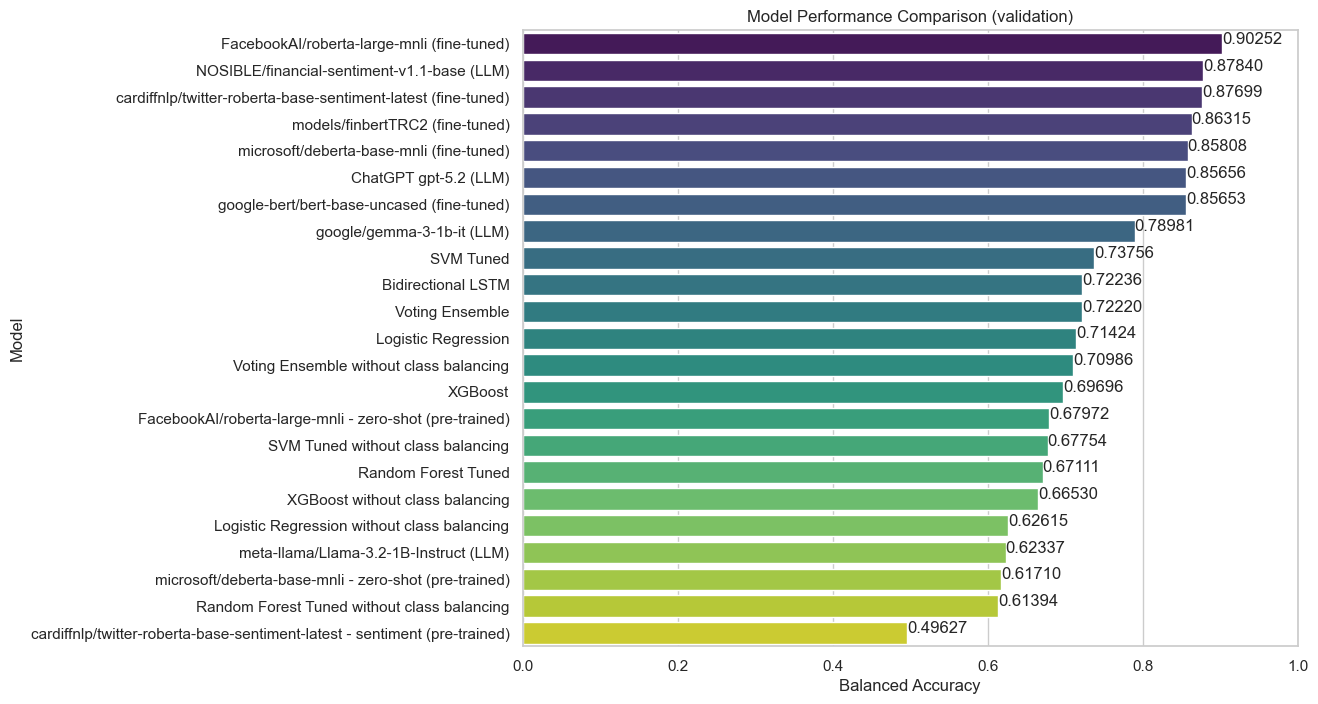

In [91]:
# Results DataFrame
res_df = pd.DataFrame(
    list(results_val.items()), columns=["Model", "Balanced Accuracy"]
).sort_values(by="Balanced Accuracy", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Balanced Accuracy", y="Model", data=res_df, palette="viridis")
plt.title("Model Performance Comparison (validation)")
plt.xlim(0, 1)
for index, value in enumerate(res_df["Balanced Accuracy"]):
    plt.text(value, index, f"{value:.5f}")
plt.show()

/var/folders/6z/x30k7lfx3s14wgz7gd9kb3yh0000gn/T/ipykernel_24972/433348795.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Balanced Accuracy", y="Model", data=res_test_df, palette="viridis")


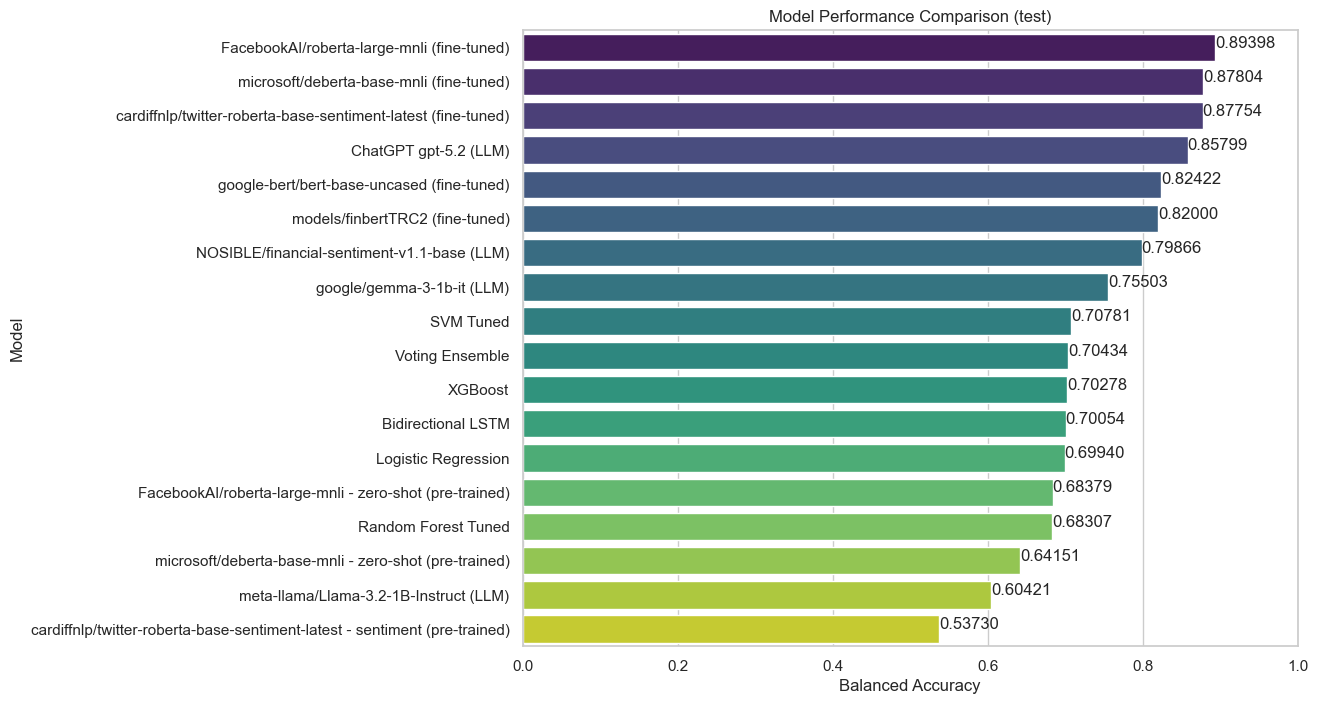

In [92]:
# Results DataFrame
res_test_df = pd.DataFrame(
    list(results_test.items()), columns=["Model", "Balanced Accuracy"]
).sort_values(by="Balanced Accuracy", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Balanced Accuracy", y="Model", data=res_test_df, palette="viridis")
plt.title("Model Performance Comparison (test)")
plt.xlim(0, 1)
for index, value in enumerate(res_test_df["Balanced Accuracy"]):
    plt.text(value, index, f"{value:.5f}")
plt.show()

### 5.1 Explainability

We will use Logistic Regression coefficients to understand which words are most indicative of positive and negative sentiments.


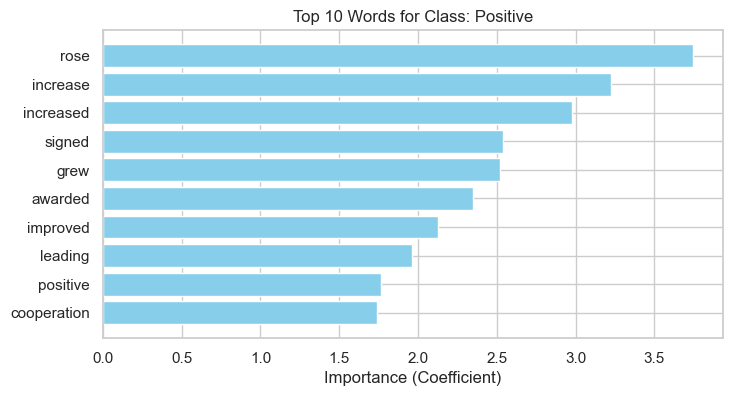

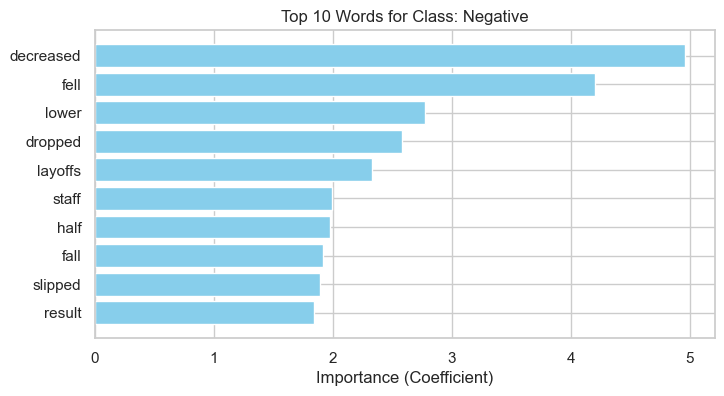

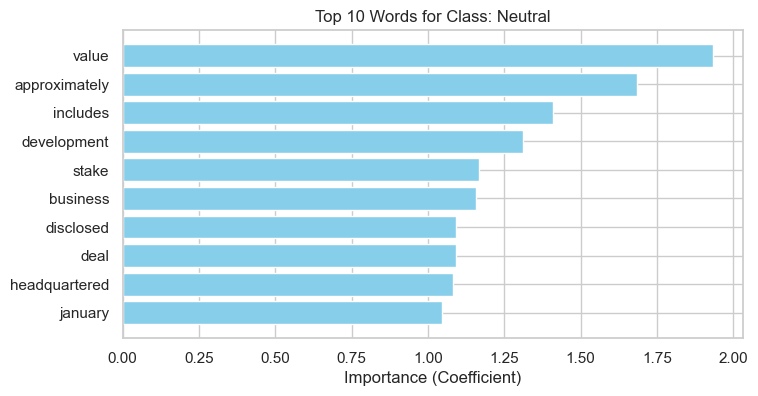

In [72]:
feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_


def plot_top_words(coef, class_index, class_name):
    top_indices = np.argsort(coef[class_index])[-10:]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = coef[class_index][top_indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top_words, top_scores, color="skyblue")
    plt.title(f"Top 10 Words for Class: {class_name}")
    plt.xlabel("Importance (Coefficient)")
    plt.show()


plot_top_words(coefs, 1, "Positive")
plot_top_words(coefs, 2, "Negative")
plot_top_words(coefs, 0, "Neutral")

In [73]:
# Create dictionary with predicted labels and true labels for the best model (RoBERTa MNLI)

sample_texts = df_fpb_val["text"].tolist()
sample_labels = df_fpb_val["label_encoded"].tolist()
eval_dataset = trainer_roberta_large_mnli.eval_dataset

predictions_obj = trainer_roberta_large_mnli.predict(eval_dataset)
logits = predictions_obj.predictions
if isinstance(logits, (list, tuple)) and len(logits) > 0:
    logits = logits[0]
if isinstance(logits, torch.Tensor):
    logits = logits.cpu().numpy()
predicted_classes = logits.argmax(axis=1)

labels_map = {0: "Neutral", 1: "Positive", 2: "Negative"}

predictions = {}
for i, (text, label) in enumerate(zip(sample_texts, sample_labels)):
    predictions[text] = {
        "predicted_label": labels_map[predicted_classes[i]],
        "true_label": labels_map[label],
    }

In [74]:
NUM_EXAMPLES = 5
print(f"\n First {NUM_EXAMPLES} text samples:")
for i, (text, label) in enumerate(
    zip(sample_texts[:NUM_EXAMPLES], sample_labels[:NUM_EXAMPLES])
):
    print(f"\n{i}. {text}")
    print(f"   True Label:      {labels_map[label]}")
    print(f"   Predicted Label: {labels_map[predicted_classes[i]]}")


 First 5 text samples:

0. `` My wife is looking forward to getting a paycheck again , '' he quipped recently as a six-knot current swirled around his anchored and heavily sponsored jet sled .
   True Label:      Neutral
   Predicted Label: Neutral

1. No financial details were revealed .
   True Label:      Neutral
   Predicted Label: Neutral

2. Filmiteollisuus Fine Ab will be transferred to Talentum Oyj in the form of a subsidiary .
   True Label:      Neutral
   Predicted Label: Neutral

3. Growth was strongest in F-Secure 's operator ISPs , mobile operators and cable operators business .
   True Label:      Positive
   Predicted Label: Positive

4. HELSINKI , Finland , Sept. 18 , 2009 ( GLOBE NEWSWIRE ) -- Ixonos Plc expands the company 's smartphone R&D services and establishes a new next-generation smartphone design unit in connection with Ixonos ' site in Jyvaeskylae .
   True Label:      Positive
   Predicted Label: Positive


In [75]:
# Select one sample of each possible error combination

wrong_samples = {}  # Key: (true_label, predicted_label) tuple

for i, (text, label, pred_class) in enumerate(
    zip(sample_texts, sample_labels, predicted_classes)
):
    if label != pred_class:
        key = (label, pred_class)
        if (
            key not in wrong_samples
        ):  # Only store the first sample for each mistake type
            wrong_samples[key] = {
                "idx": i,
                "text": text,
                "true_label": label,
                "predicted_label": pred_class,
            }

for true_label, pred_label in sorted(wrong_samples.keys()):
    ex = wrong_samples[(true_label, pred_label)]
    print(f"\n  Idx: {ex['idx']}")
    print(f"    True label: {labels_map[ex['true_label']]} ({ex['true_label']})")
    print(
        f"    Predicted: {labels_map[ex['predicted_label']]} ({ex['predicted_label']})"
    )
    print(f"    Text: {ex['text']}\n")


  Idx: 11
    True label: Neutral (0)
    Predicted: Positive (1)
    Text: It also has potential clients in the growing environmental and recycling technology sectors .


  Idx: 9
    True label: Neutral (0)
    Predicted: Negative (2)
    Text: This one was at one time targeted for June 5 , but if we had to guess , it 's been pushed back -- maybe we 're crazy , but we feel like it has n't leaked enough to meet that date at this point .


  Idx: 93
    True label: Positive (1)
    Predicted: Neutral (0)
    Text: During the past decade it has gradually divested noncore assets and bought several sports equipment makers , including California-based Fitness Products International and Sparks , Nevada-based ATEC , a leading maker of baseball and softball pitching machines .


  Idx: 28
    True label: Negative (2)
    Predicted: Neutral (0)
    Text: The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Inc

### 5.1.1 Explainability (LIME and SHAP) - RoBERTa Fine-Tuned

To understand the predictions of the fine-tuned RoBERTa model, as it is the best model among those tested, we applied explainability techniques.

We used **LIME** (Local Interpretable Model-agnostic Explanations) and **SHAP** (SHapley Additive exPlanations).


In [76]:
%pip install lime shap

Note: you may need to restart the kernel to use updated packages.


### LIME


In [77]:
from lime.lime_text import LimeTextExplainer
import torch
import torch.nn.functional as F

# Ensure model is in evaluation mode
trainer_roberta_large_mnli.model.eval()
device = utils.get_device()
trainer_roberta_large_mnli.model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [78]:
# --- Explainability with LIME ---


# Prediction wrapper function for LIME
def predict_probs_roberta(texts):
    if isinstance(texts, str):
        texts = [texts]

    # Tokenization
    inputs = trainer_roberta_large_mnli.eval_dataset.tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=64,  # Reduced max_length to save memory
    ).to(trainer_roberta_large_mnli.model.device)

    with torch.no_grad():
        logits = trainer_roberta_large_mnli.model(**inputs).logits
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()

    return probs


# Initialize Explainer
explainer_lime = LimeTextExplainer(class_names=["Neutral", "Positive", "Negative"])

# Choose an interesting sample
idx_sample = 10
text_sample = df_fpb_val["text"].iloc[idx_sample]
true_label = df_fpb_val["label_encoded"].iloc[idx_sample]
labels_map = {0: "Neutral", 1: "Positive", 2: "Negative"}

print(f"sample Text: {text_sample}")
print(f"True Label: {labels_map[true_label]}")
print(f"Predicted Label: {labels_map[predicted_classes[idx_sample]]}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Generate explanation
exp = explainer_lime.explain_instance(
    text_sample, predict_probs_roberta, num_features=10, num_samples=1000
)

try:
    from IPython.display import display, HTML

    display(HTML(exp.as_html()))
except (ImportError, AttributeError):
    print("\n=== LIME Explanation ===")
    print(f"Predicted probabilities: {exp.predict_proba}")
    print("\nMain features that contributed:")
    for feature, weight in exp.as_list():
        print(f"  {feature}: {weight:.4f}")

sample Text: ( ADP News ) - Jan 27 , 2009 - Finnish industrial machinery company Vaahto Group Ltd Oyj ( HEL : WAT1S ) said today that its subsidiary Vaahto Ltd would cut 15 jobs in Finland .
True Label: Negative
Predicted Label: Negative


### SHAP


In [79]:
# --- Example: SHAP with RoBERTa Large MNLI (best model)---

model_roberta = trainer_roberta_large_mnli.model
tokenizer_roberta = trainer_roberta_large_mnli.eval_dataset.tokenizer
device_roberta = utils.get_device()
model_roberta.eval()
model_roberta.to(device_roberta)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

if hasattr(torch, "mps") and torch.mps.is_available():
    torch.mps.empty_cache()

print("Model and tokenizer loaded successfully!")

shap_explainer_roberta = evaluation.create_shap_explainer(
    model=model_roberta,
    tokenizer=tokenizer_roberta,
    device=device_roberta,
    output_names=["Neutral", "Positive", "Negative"],
)

print("SHAP Explainer created successfully!")

shap_values_roberta = evaluation.compute_shap_values(
    explainer=shap_explainer_roberta,
    texts=df_fpb_val["text"].tolist(),
    batch_size=2,
)

print(f"\nSHAP values calculated!")

Model and tokenizer loaded successfully!
SHAP Explainer created successfully!


PartitionExplainer explainer: 486it [03:06,  2.51it/s]                         



SHAP values calculated!



=== SHAP: Summary for Neutral ===


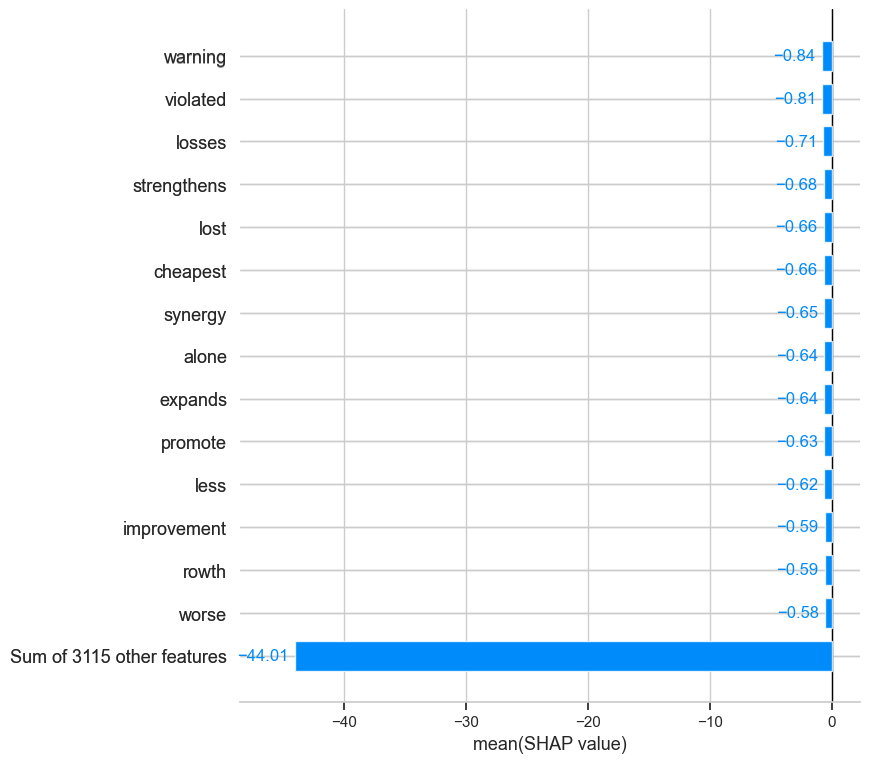


=== SHAP: Summary for Positive ===


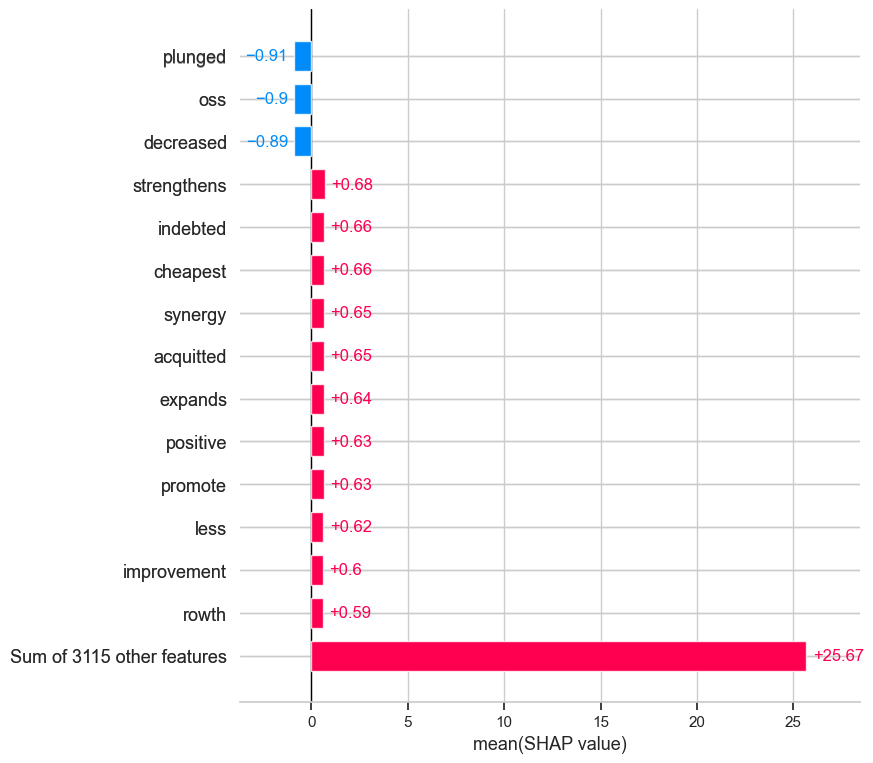


=== SHAP: Summary for Negative ===


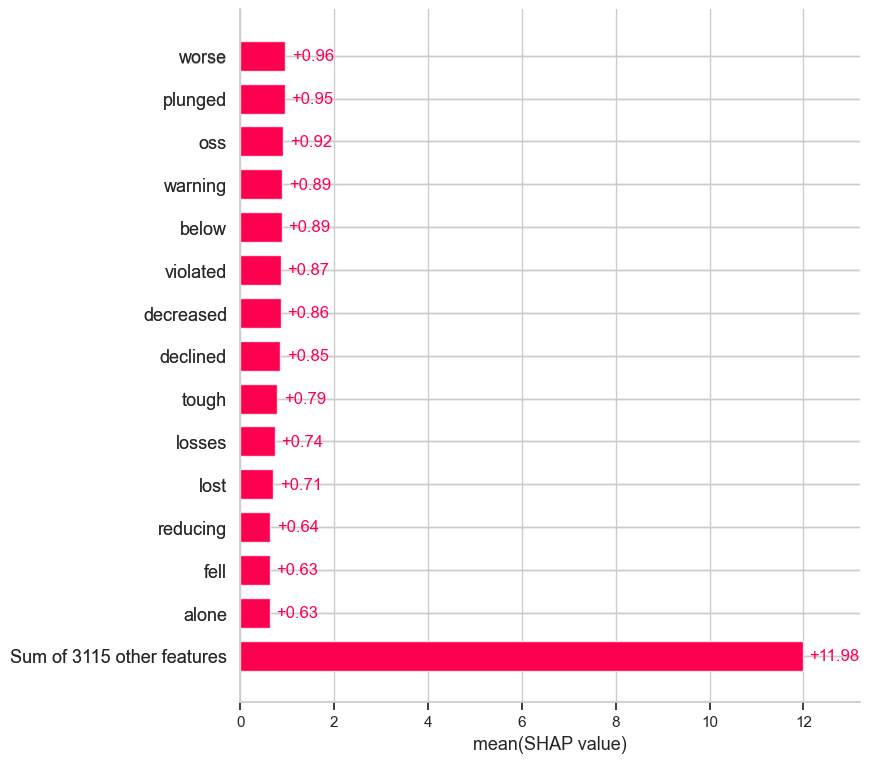

In [80]:
evaluation.plot_shap_summary(shap_values_roberta)


=== Sample 93 ===
Text: During the past decade it has gradually divested noncore assets and bought several sports equipment makers , including California-based Fitness Products International and Sparks , Nevada-based ATEC , a leading maker of baseball and softball pitching machines .
True Label: Positive
Predicted: Neutral



=== Waterfall Plot for Neutral ===


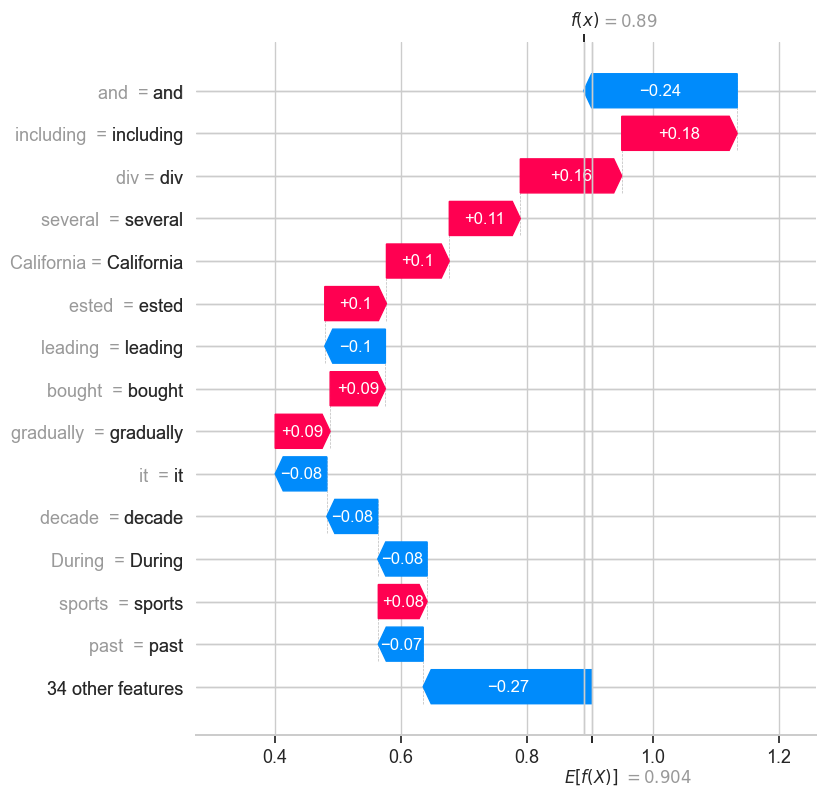


=== Waterfall Plot for Positive ===


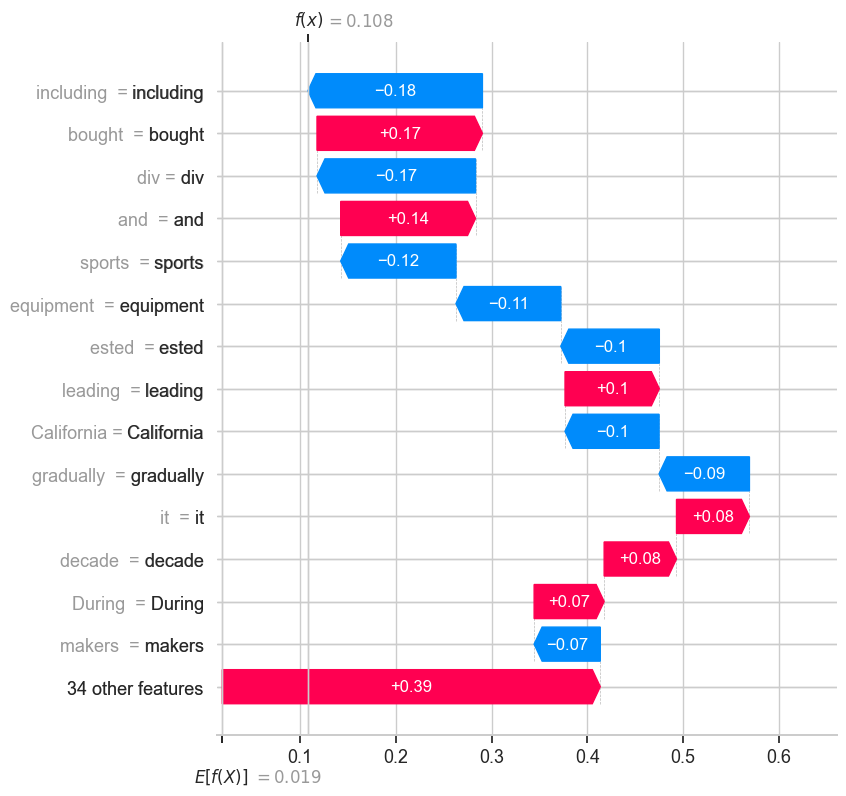


=== Waterfall Plot for Negative ===


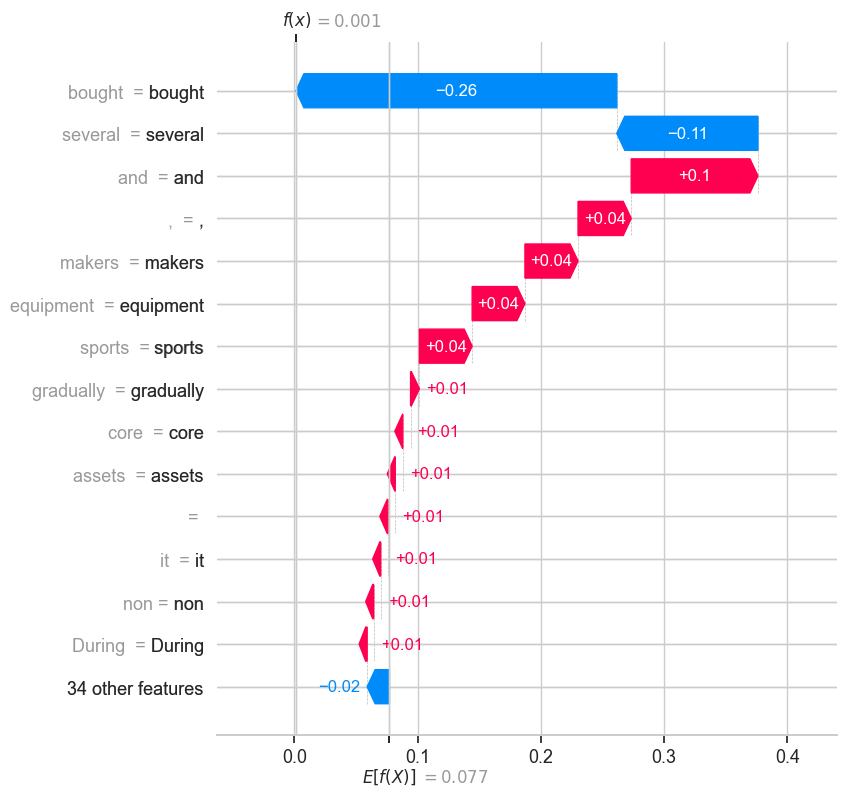

In [81]:
evaluation.analyse_sample(93, sample_texts, predictions, shap_values_roberta)


=== Sample 52 ===
Text: Operating profit before non-recurring items was EUR 8.3 mn in the first nine months of 2008 , compared to EUR 8.4 in the corresponding period in 2007 .
True Label: Negative
Predicted: Positive



=== Waterfall Plot for Neutral ===


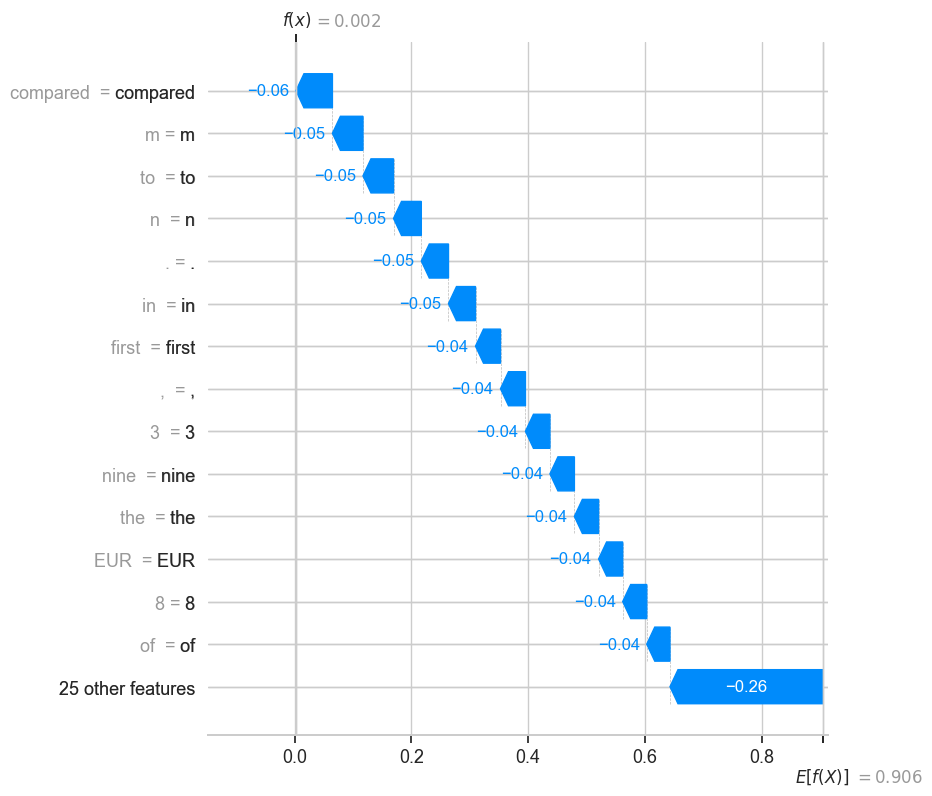


=== Waterfall Plot for Positive ===


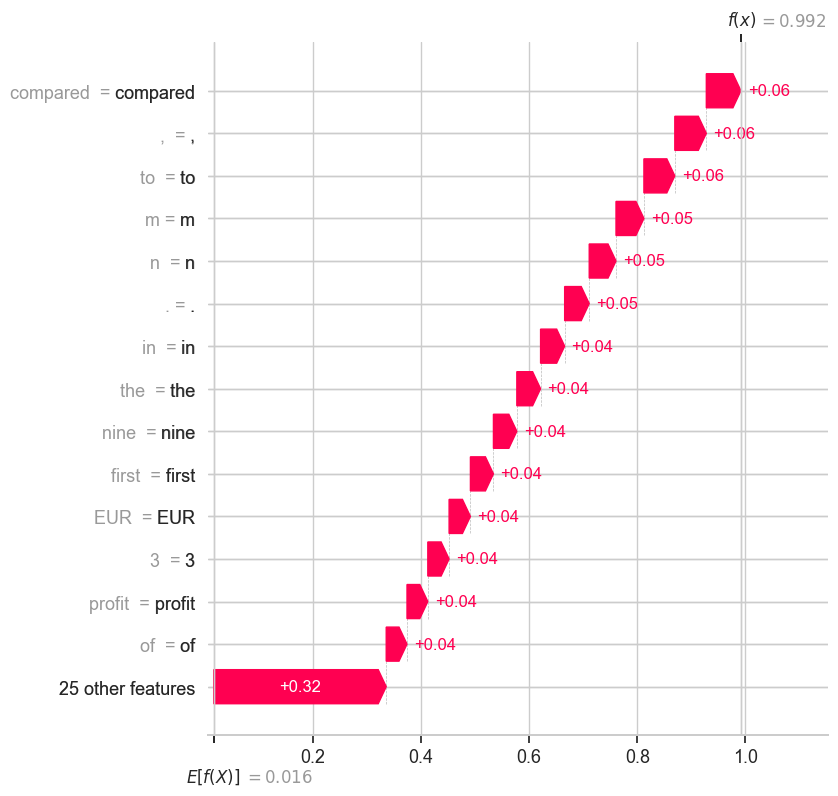


=== Waterfall Plot for Negative ===


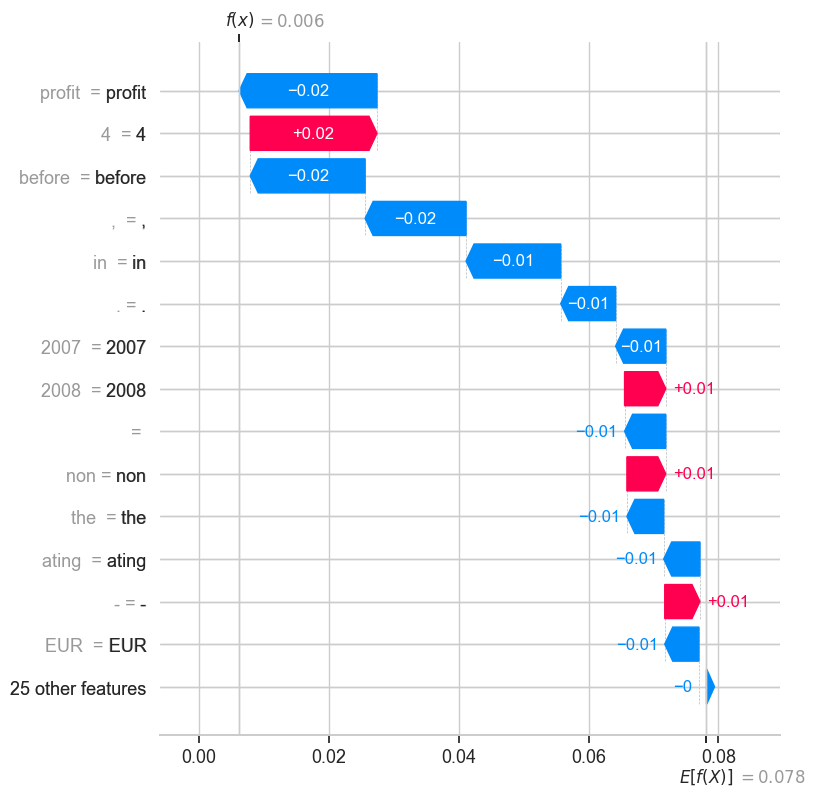

In [82]:
evaluation.analyse_sample(52, sample_texts, predictions, shap_values_roberta)

## 6. Future Work

### LSTM
* Hyperparameter search

### Transformers
* Data augmentation
* Training and/or testing on other datasets. Examples:
  * https://huggingface.co/datasets/NOSIBLE/financial-sentiment
  * https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment
* Hyperparameter search using a library such as [Optuna](https://optuna.org/)
  

### LLMs
* [SFT](https://huggingface.co/docs/trl/en/sft_trainer) - Supervised Fine-Tuning.
* [PEFT](https://huggingface.co/docs/peft/en/index) - Parameter-Efficient Fine-Tuning